# **MIE 1517 Introduction to Deep Learning – Fall 2023** <br>
# **Project: AgriLeaf Detect - Crop Disease Detection** <br>
# **Project Final Report** <br>

**Team 4**<br>
<br>
*   Sudarsanamurthy Tenneti Prabakaramurthy
*   Anbumanivel Mohan Suganthi
*   Gokul Ravi

**Colab link**: https://colab.research.google.com/drive/11BI-ELpQ6Mpshl_RsHk9pQwgFtTirCWg?usp=sharing

# **Introduction and Goal of the Project**

##**Introduction:**<br>
Agriculture, the lifeblood of human civilization, faces significant challenges from crop diseases. These diseases inflict devastating consequences, leading to economic losses, reduced food production, and jeopardized food security. Farmers desperately need accurate and rapid disease identification to mitigate these risks.

##**Problem Statement:** <br>
Traditional methods of disease identification, often relying on visual inspections by experts, are plagued by limitations:

**Time-consuming:** <br>
Manual inspections require significant time and effort, delaying crucial interventions.

**Labor-intensive:**<br>
Expertise in disease identification is scarce, limiting access to essential resources.

**Limited accuracy:** <br> Human error and subjectivity can lead to misdiagnosis and delayed responses.<br><br>
These limitations hinder farmers' ability to effectively combat crop diseases, resulting in increased costs, reduced yields, and potential crop failures.

##**Solution:**
To overcome these limitations, we propose a revolutionary solution: deep learning-based crop disease detection using an ensemble approach. This solution leverages the power of artificial intelligence to automate and significantly improve disease identification.

Deep learning excels at image recognition and pattern detection, making it ideal for analyzing plant leaves. By harnessing this technology in an ensemble approach, we combine the strengths of multiple deep learning models to achieve even greater accuracy and robustness. This approach offers several advantages:

Improved accuracy: Combining multiple models reduces the impact of individual model biases, leading to more accurate disease diagnoses.
Reduced overfitting: Ensemble models are less prone to overfitting the training data, resulting in better generalization to unseen data.
Increased robustness: Combining diverse models enhances the overall robustness of the system, making it less susceptible to noise and variations in data.
Methodology:
Our deep learning solution with an ensemble approach involves the following steps:

**1. Dataset Compilation:**

We curate a diverse dataset encompassing various crops and a wide range of diseases, providing the foundation for model training and validation.

**2. Pretrained Models:**

We utilize state-of-the-art pretrained models like AlexNet, ResNet, GoogleNet, and VGG, which have been trained on massive datasets and possess powerful feature extraction capabilities.

**3. Individual Model Training:**

Each pretrained model is fine-tuned on the curated dataset, specializing in recognizing the unique patterns and characteristics associated with different diseases.

**4. Ensemble Creation:**

We combine the trained models using an ensemble learning technique like majority voting or stacking. This combines the individual strengths of each model to create a more robust and accurate prediction system.

**5. Prediction Mechanism:**

The ensemble model serves as a real-time prediction tool. When presented with an image of a plant leaf, it analyzes the visual features and patterns, providing farmers with immediate insights into the presence and type of disease.

##**Goal:**<br>
By combining cutting-edge deep learning technology with an ensemble approach, our solution offers a powerful tool for crop disease detection. This technology empowers farmers to:

**Make informed decisions:** Real-time disease identification allows for data-driven decisions regarding treatment and resource allocation. <br>
**Protect yields:** Accurate and timely diagnosis helps farmers intervene quickly and effectively, safeguarding their crops from devastating losses.<br>
**Increase profitability:** Improved productivity and reduced costs enhance farmers' overall profitability and sustainability.<br><br>
This innovative solution holds immense potential to revolutionize crop disease detection, ensuring food security and contributing to a more sustainable agricultural future.

#**DATA LOADING**

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import pandas as pd

The below code downloads the truncated dataset with the train, valid and test split in 60:20:20 ratio, from our google drive storage.

In [3]:
# Downloading the dataset "Dataset.zip" from gdrive
! gdown --id 1EnL3kIYOh0PHgM027wn03g1cyoj8EtA1

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1EnL3kIYOh0PHgM027wn03g1cyoj8EtA1
To: /content/Dataset.zip
100% 523M/523M [00:07<00:00, 73.9MB/s]


In [4]:
import zipfile
with zipfile.ZipFile('Dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('dataset')

The below code is to preprocess the images to make sure that it is inline with the input images accepted by the pretrained models. The code also create dataloaders of the train, valid and test data sets.

In [5]:
def get_data_loaders(batch_size: 32, **kwargs):

  train_dataset_path = '/content/dataset/Dataset/Train'
  val_dataset_path = '/content/dataset/Dataset/Valid'
  test_dataset_path = '/content/dataset/Dataset/Test'

  mean = [0.485, 0.456, 0.406] #Commonly used values for RGB channels
  std = [0.229, 0.224, 0.225] #Commonly used values for RGB channels

  # Data Transforms
  data_transforms = {
      'train':
        transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ]),
      'val':
        transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ]),
      'test':
        transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])
        }

  # Image Datasets
  image_datasets = {
                    'train': ImageFolder(train_dataset_path, data_transforms['train']),
                    'val': ImageFolder(val_dataset_path, data_transforms['val']),
                    'test': ImageFolder(test_dataset_path, data_transforms['test'])
                   }

  # Dataloaders
  dataloaders = {
                'train': DataLoader(image_datasets['train'],
                                    batch_size= batch_size,
                                    shuffle=True,
                                    num_workers=1),
                'val': DataLoader(image_datasets['val'],
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=1),
                'test': DataLoader(image_datasets['test'],
                                   batch_size=batch_size,
                                   shuffle=False,
                                   num_workers=1)
                }

  return image_datasets, dataloaders

The below code provides the various classes available in the dataset. The classname contains the name of the crop along with the disease affecting the crop leaf.

In [6]:
# Class Name
data, dataloader = get_data_loaders(batch_size= 32)
class_names= data['train'].classes
num_classes = len(class_names)
print("Total Number of Classes:", num_classes)
class_names

Total Number of Classes: 38


['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

The below code provides the number of images available in train, valid and test datasets.

In [7]:
# Total number of images in Train, Val, and Test
dir = '/content/dataset/Dataset/'
sub_dir = ['Train', 'Valid', 'Test']

for i in sub_dir:
  subdir_path = os.path.join(dir, i)
  count = 0
  for subfolder in os.listdir(subdir_path):
    subfolder_path = os.path.join(subdir_path, subfolder)
    if os.path.isdir(subfolder_path):
      num_files = len(os.listdir(subfolder_path))
      count += num_files
  print(f"Total number of images in {i}: {count}")

Total number of images in Train: 19000
Total number of images in Valid: 6460
Total number of images in Test: 6460


From the above you can clearly see that the datasets are divided in 60:20:20 split.

#**VISUALIZATION OF DATASET**

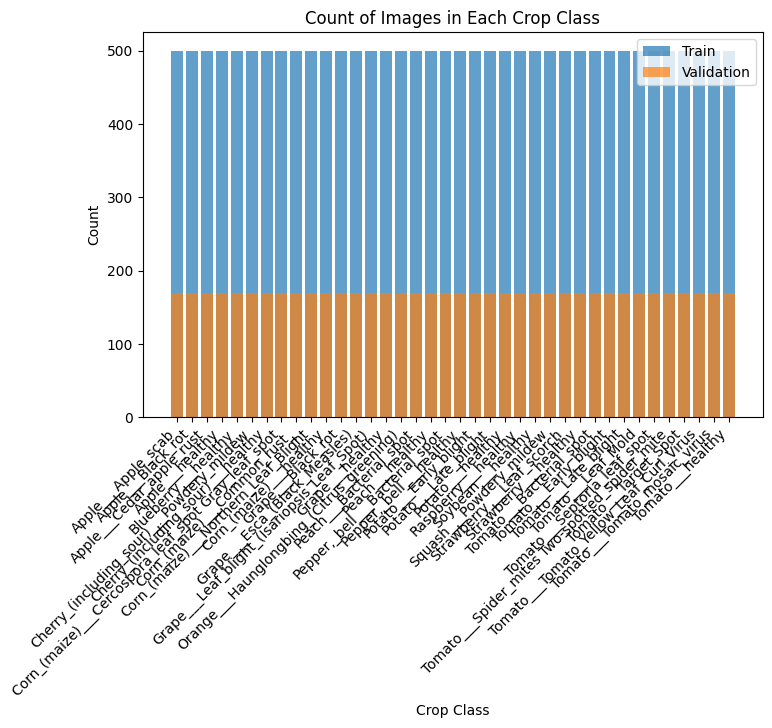

In [7]:
# Bar Plot for Count of Images in Each Crop Class
train_dataset_path = '/content/dataset/Dataset/Train'
val_dataset_path = '/content/dataset/Dataset/Valid'
test_dataset_path = '/content/dataset/Dataset/Test'
train_counts = [len(os.listdir(os.path.join(train_dataset_path, class_name))) for class_name in class_names]
val_counts = [len(os.listdir(os.path.join(val_dataset_path, class_name))) for class_name in class_names]

plt.figure(figsize=(8, 5))
plt.bar(class_names, train_counts, label='Train', alpha=0.7)
plt.bar(class_names, val_counts, label='Validation', alpha=0.7)
plt.xlabel('Crop Class')
plt.ylabel('Count')
plt.title('Count of Images in Each Crop Class')
plt.legend(loc='best')
plt.xticks(rotation=45, ha='right')
plt.show()

From the above graph, we can see that the data is homogenous and there is equal number of images in train and valid datasets for all classes. This makes sure that the dataset is balanced and our model is fair and ethical according to the current AI / ML standards.

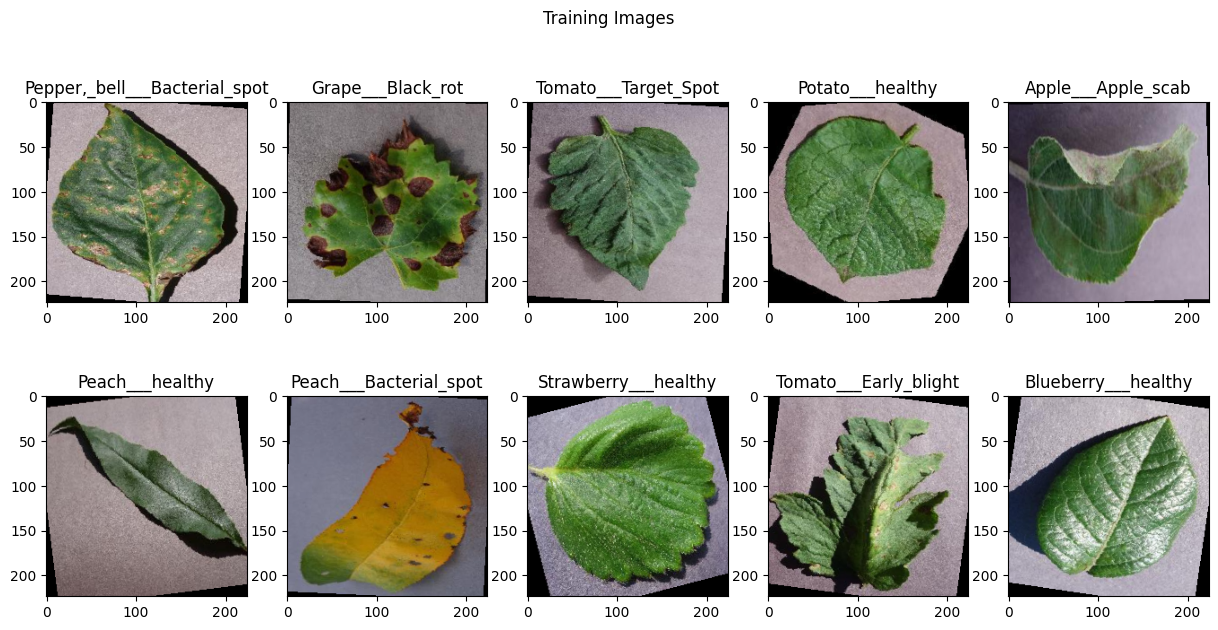

In [8]:
def plot_images(dataloader, title, num_images=10):

    data_iter = next(iter(dataloader))
    images, labels = data_iter

    # Denormalize the images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = images.numpy().transpose((0, 2, 3, 1))
    images = std * images + mean                        # Comment this line for normalized image
    images = np.clip(images, 0, 1)                      # Comment this line for normalized image

    plt.figure(figsize=(15, 7))
    for i in range(num_images):
      plt.subplot(2, 5, i + 1)
      plt.imshow(images[i])
      plt.title(class_names[labels[i]])
      plt.suptitle(title)
    plt.show()

# Plotting the training Images
_,dataloaders= get_data_loaders(batch_size=32)
plot_images(dataloaders['train'], "Training Images")


The above show the different images of crop leaves present inside our dataset.

In [12]:
use_cuda = True and torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
device

device(type='cuda')

#**MODEL BUILDING**

## **CNN**

The "CropDisease" class defines a convolutional neural network (CNN) for image classification with four convolutional layers followed by max-pooling layers and 3 fully-connected layers. The convolutional layers extract hierarchical features from the input image, and the fully connected layers (FCLs) at the end process the flattened output for final classification. The network uses Rectified Linear Unit (ReLU) activation functions throughout, with the architecture specified by the given convolutional and FCL parameters.

In [10]:
img_size= 224
output_channels= num_classes

class CropDisease(nn.Module):

  def __init__(self, kernel_size: int = 3):
    super(CropDisease, self).__init__()
    self.name = f'{self.__class__.__name__}_{kernel_size}'

    conv_fcl = 256
    maxpool_1 = 2

    self.conv1 = nn.Conv2d(3, 32, kernel_size)
    self.pool1 = nn.MaxPool2d(maxpool_1, maxpool_1)
    self.conv2 = nn.Conv2d(32, 128, kernel_size )
    self.pool2 = nn.MaxPool2d(maxpool_1, maxpool_1)
    self.conv3 = nn.Conv2d(128, 512, kernel_size)
    self.conv4 = nn.Conv2d(512, conv_fcl, kernel_size)

    dim1 = math.floor((1 / maxpool_1) * (img_size - kernel_size + 1))  #Dimension after first conv and maxpool1
    dim2 = math.floor((1 / maxpool_1) * (dim1 - kernel_size + 1))      #Dimension after second conv and maxpool2
    dim3 = math.floor((1 / maxpool_1) * (dim2 - kernel_size + 1))      #Dimension after third conv and maxpool1
    dim4 = math.floor((1 / maxpool_1) * (dim3 - kernel_size + 1))      #Dimension after foutrh conv and maxpool2

    self.fcl_input = (dim4 * dim4) * conv_fcl
    self.fcl1 = nn.Linear(self.fcl_input, 2048)
    self.fcl2 = nn.Linear(2048, output_channels)

  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.pool1(F.relu(self.conv3(x)))
    x = self.pool2(F.relu(self.conv4(x)))

    x = x.view(-1, self.fcl_input)  #flatten before FCL
    x = F.relu(self.fcl1(x))
    x = self.fcl2(x)

    return x


Below are the necessary functions required to train and evaluate the models. The "TrainingResult" class encapsulates training and validation accuracy along with corresponding losses, providing a convenient way to store and represent these metrics. The "get_model_path" function generates a model file path based on input parameters like model name, batch size, learning rate, and epoch. Lastly, the "get_accuracy" function evaluates the accuracy of a given model on a provided dataset, returning the overall accuracy by comparing predicted and actual labels.

In [41]:
class TrainingResult:
    def __init__(self,
        training_accuracy: float,
        training_loss: float,
        validation_accuracy: float,
        validation_loss: float):

        self.training_accuracy = training_accuracy
        self.training_loss = training_loss
        self.validation_accuracy = validation_accuracy
        self.validation_loss = validation_loss

    def __repr__(self):
        return (
            f'\nTrainingResult(Training_accuracy={self.training_accuracy},'
            f'\nTraining_loss={self.training_loss},'
            f'\nValidation_accuracy={self.validation_accuracy},'
            f'\nValidation_loss={self.validation_loss})')


def get_model_path(name, batch_size, learning_rate, epoch):
  path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
  return path


def get_accuracy(model, data):
  model.eval()
  correct, total = 0, 0
  for inputs, labels in data:
    inputs = inputs.to(device)
    labels = labels.to(device)
    output = model(inputs)
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += labels.shape[0]
  return correct / total

The "train_model" function is designed to train a given model using PyTorch. It handles various deep learning architectures. The training process includes optimizing with Adam optimizer, calculating loss with CrossEntropyLoss, and adjusting learning rates. It monitors and records training and validation accuracy and loss over epochs, saving the best-performing model. Additionally, it visualizes the training and validation accuracy and loss using matplotlib. The function returns a 'TrainingResult' object containing the final metrics.

In [42]:
def train_model(model, dataloaders, batch_size= 32, num_epochs=10, learning_rate= 0.001):

  criterion = nn.CrossEntropyLoss()
  if model.name == 'Resnet50':
    optimizer = optim.Adam(model.resnet.fc.parameters(), lr= learning_rate)
  elif model.name == 'AlexNet':
    optimizer = optim.Adam(model.alexnet.classifier.parameters(), lr=learning_rate)
  elif model.name == 'VGG19':
    optimizer = optim.Adam(model.vgg.classifier.parameters(), lr=learning_rate)
  elif model.name == 'GoogLeNet':
    optimizer = optim.Adam(model.googlenet.fc.parameters(), lr=learning_rate)
  else:
    optimizer = optim.Adam(model.parameters(), lr= learning_rate)

  train_err = []
  train_loss = []
  val_err = []
  val_loss = []

  best_val_acc = 0.0
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  for epoch in range(num_epochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10,'\n')

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()          # Training Mode
      else:
        model.eval()           # Evaluation Mode

      total_loss = 0.0
      total_err = 0.0
      total_samples = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        _, preds = torch.max(outputs, 1)
        total_loss += loss.item() * inputs.size(0)
        total_err += torch.sum(preds == labels.data)
        total_samples += len(labels)

      epoch_loss = total_loss / total_samples
      epoch_acc = total_err.double() / total_samples

      print('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'train':
        train_loss.append(epoch_loss)
        train_err.append(epoch_acc.item())
      else:
        val_loss.append(epoch_loss)
        val_err.append(epoch_acc.item())

        if epoch_acc > best_val_acc:
          best_val_acc = epoch_acc
          model_path = get_model_path(model.name, batch_size, learning_rate, epoch+1)
          torch.save(model.state_dict(), model_path)

  plt.figure(figsize=(10,4))
  plt.title('Training Vs. Validation Accuracy')
  n_epochs = len(train_err)
  plt.plot(range(1, n_epochs + 1), train_err, label='Train')
  plt.plot(range(1, n_epochs + 1), val_err, label='Validation')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='best')
  plt.show()

  plt.figure(figsize=(10,4))
  plt.title('Training Vs. Validation Loss')
  plt.plot(range(1, n_epochs + 1), train_loss, label='Train')
  plt.plot(range(1, n_epochs + 1), val_loss, label='Validation')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='best')
  plt.show()

  print('Final Training Loss: {:.4f}, Accuracy: {:.4f}'.format(train_loss[-1], train_err[-1]))
  print('Final Validation Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss[-1], val_err[-1]))

  return TrainingResult(train_err[-1], train_loss[-1], val_err[-1], val_loss[-1])

----------
Epoch 1/10
---------- 

train loss: 2.6793, acc: 0.2461
val loss: 1.7613, acc: 0.4601
----------
Epoch 2/10
---------- 

train loss: 1.5322, acc: 0.5252
val loss: 1.1935, acc: 0.6209
----------
Epoch 3/10
---------- 

train loss: 1.1179, acc: 0.6487
val loss: 0.9720, acc: 0.6974
----------
Epoch 4/10
---------- 

train loss: 0.8843, acc: 0.7177
val loss: 0.8418, acc: 0.7299
----------
Epoch 5/10
---------- 

train loss: 0.7262, acc: 0.7698
val loss: 0.6917, acc: 0.7808
----------
Epoch 6/10
---------- 

train loss: 0.6025, acc: 0.8058
val loss: 0.6361, acc: 0.7988
----------
Epoch 7/10
---------- 

train loss: 0.4914, acc: 0.8428
val loss: 0.5582, acc: 0.8368
----------
Epoch 8/10
---------- 

train loss: 0.4309, acc: 0.8626
val loss: 0.5739, acc: 0.8331
----------
Epoch 9/10
---------- 

train loss: 0.3652, acc: 0.8868
val loss: 0.5308, acc: 0.8423
----------
Epoch 10/10
---------- 

train loss: 0.3195, acc: 0.8967
val loss: 0.4591, acc: 0.8647


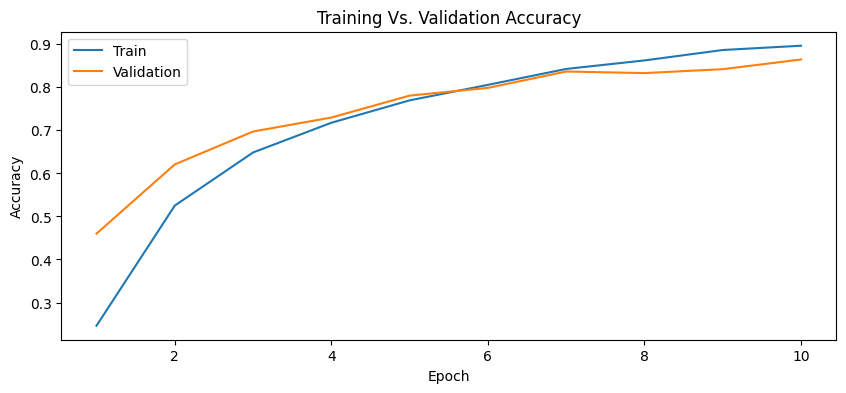

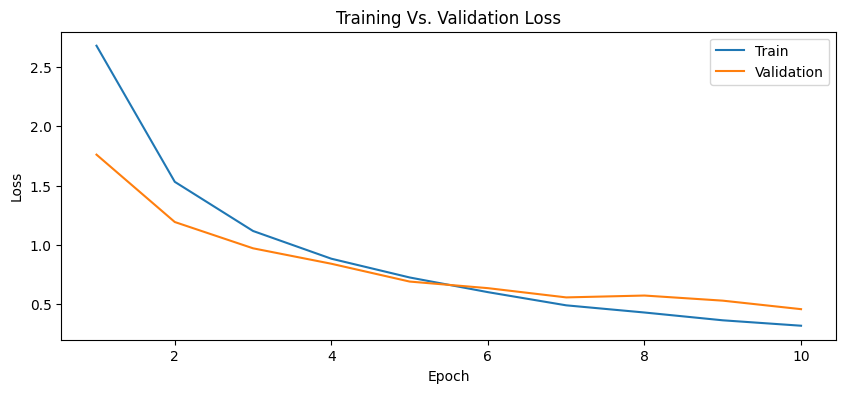

Final Training Loss: 0.3195, Accuracy: 0.8967
Final Validation Loss: 0.4591, Accuracy: 0.8647



TrainingResult(Training_accuracy=0.8967368421052632,
Training_loss=0.31954977971001675,
Validation_accuracy=0.8647058823529412,
Validation_loss=0.45910871706141776)

In [14]:
# Training CNN (CropDisease) model
cnn_model = CropDisease().to(device)
hyper_params = dict(batch_size=32, learning_rate=0.0015, num_epochs= 10)
_, dataloaders = get_data_loaders(** hyper_params)
train_model(cnn_model, dataloaders, ** hyper_params)

### **Sanity Checking: Overfitting to small dataset**

Sanity checking is crucial in the development of models to ensure that basic, expected functionalities are working correctly. It helps catch fundamental errors early in the process, providing confidence that the system is functioning as intended before more extensive testing. Sanity checks act as a quick verification step to make sure there are no big problems and stop mistakes from causing bigger issues later on.

In [ ]:
with zipfile.ZipFile('sanity.zip', 'r') as zip_ref:
    zip_ref.extractall('personal_dataset')

In [ ]:
# Transforming the images to Tensors and resizing
data_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                     ])

data_dir = '/content/personal_dataset'

sanity_data = ImageFolder(data_dir, transform=data_transform)

train_size = int(0.8 * len(sanity_data))
val_size = len(sanity_data) - train_size
train_set, val_set = torch.utils.data.random_split(sanity_data, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader_sanity = DataLoader(train_set, batch_size=256)
val_loader_sanity = DataLoader(val_set, batch_size=256)

dataloaders_sanity = {'train': train_loader_sanity,
                      'val': val_loader_sanity
                      }


----------
Epoch 1/10
---------- 

train loss: 3.6056, acc: 0.5312
val loss: 0.0000, acc: 1.0000
----------
Epoch 2/10
---------- 

train loss: 0.0000, acc: 1.0000
val loss: 0.0000, acc: 1.0000
----------
Epoch 3/10
---------- 

train loss: 0.0000, acc: 1.0000
val loss: 0.0000, acc: 1.0000
----------
Epoch 4/10
---------- 

train loss: 0.0000, acc: 1.0000
val loss: 0.0000, acc: 1.0000
----------
Epoch 5/10
---------- 

train loss: 0.0000, acc: 1.0000
val loss: 0.0000, acc: 1.0000
----------
Epoch 6/10
---------- 

train loss: 0.0000, acc: 1.0000
val loss: 0.0000, acc: 1.0000
----------
Epoch 7/10
---------- 

train loss: 0.0000, acc: 1.0000
val loss: 0.0000, acc: 1.0000
----------
Epoch 8/10
---------- 

train loss: 0.0000, acc: 1.0000
val loss: 0.0000, acc: 1.0000
----------
Epoch 9/10
---------- 

train loss: 0.0000, acc: 1.0000
val loss: 0.0000, acc: 1.0000
----------
Epoch 10/10
---------- 

train loss: 0.0000, acc: 1.0000
val loss: 0.0000, acc: 1.0000


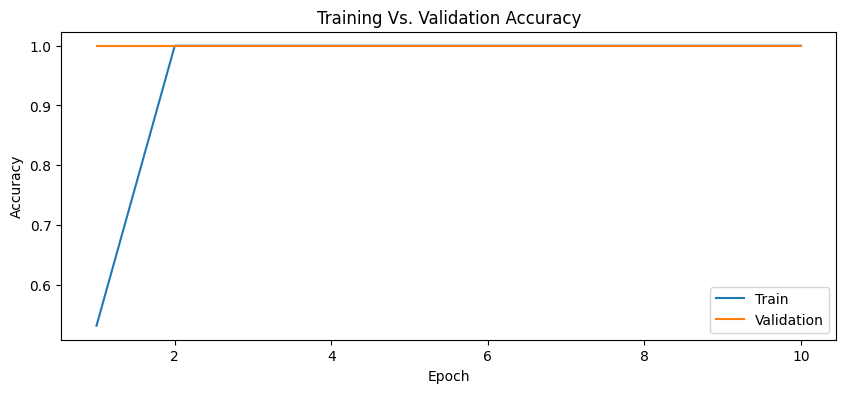

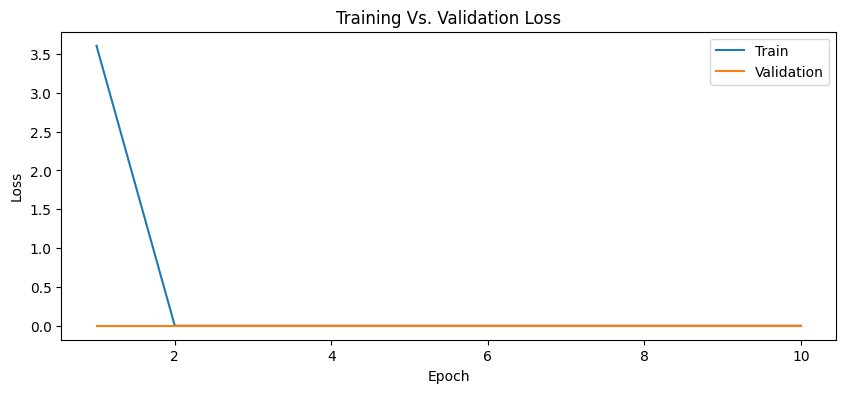

Final Training Loss: 0.0000, Accuracy: 1.0000
Final Validation Loss: 0.0000, Accuracy: 1.0000



TrainingResult(Training_accuracy=1.0,
Training_loss=0.0,
Validation_accuracy=1.0,
Validation_loss=0.0)

In [ ]:
sanity_model = CropDisease().to(device)
sanity_hyper_params = dict(batch_size=256, learning_rate=0.01, num_epochs=10)
train_model(sanity_model, dataloaders_sanity, **sanity_hyper_params)

### **Hyperparameter Tuning**

Hyperparameter tuning is essential to optimize the performance of a machine learning model by finding the most effective configuration of hyperparameters. Hyperparameters are external settings that influence the learning process but are not learned from the data. Tuning involves systematically adjusting these hyperparameters to achieve better model accuracy, generalization, and overall efficiency.

Hyperparameters such as Kernal size, batch size, learning rate and epoch were carefully chosen to maximize the model's validation accuracy.

#### (i) Kernel Size = 5, Batch size = 64

----------
Epoch 1/10
---------- 

train loss: 3.0811, acc: 0.1760
val loss: 2.4502, acc: 0.2772
----------
Epoch 2/10
---------- 

train loss: 2.1832, acc: 0.3547
val loss: 1.9398, acc: 0.4005
----------
Epoch 3/10
---------- 

train loss: 1.7065, acc: 0.4765
val loss: 1.3948, acc: 0.5728
----------
Epoch 4/10
---------- 

train loss: 1.2962, acc: 0.6007
val loss: 1.1518, acc: 0.6336
----------
Epoch 5/10
---------- 

train loss: 1.0737, acc: 0.6642
val loss: 0.9710, acc: 0.6935
----------
Epoch 6/10
---------- 

train loss: 0.9690, acc: 0.6965
val loss: 0.9132, acc: 0.7125
----------
Epoch 7/10
---------- 

train loss: 0.8791, acc: 0.7207
val loss: 0.9036, acc: 0.7119
----------
Epoch 8/10
---------- 

train loss: 0.7837, acc: 0.7467
val loss: 0.8695, acc: 0.7300
----------
Epoch 9/10
---------- 

train loss: 0.7124, acc: 0.7706
val loss: 0.7092, acc: 0.7814
----------
Epoch 10/10
---------- 

train loss: 0.6589, acc: 0.7899
val loss: 0.7342, acc: 0.7661


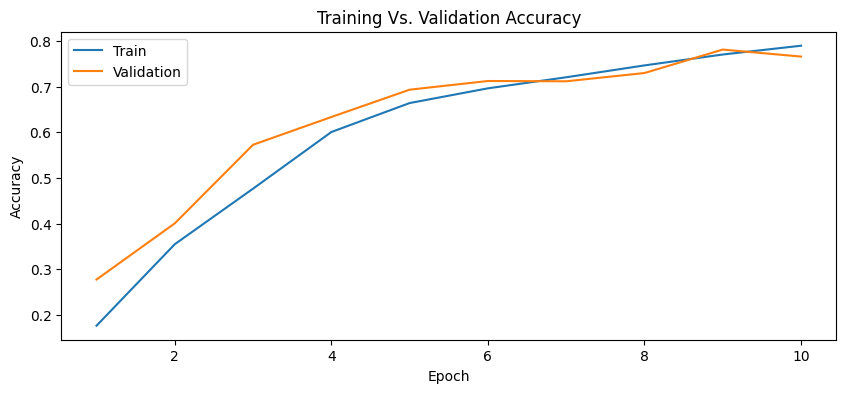

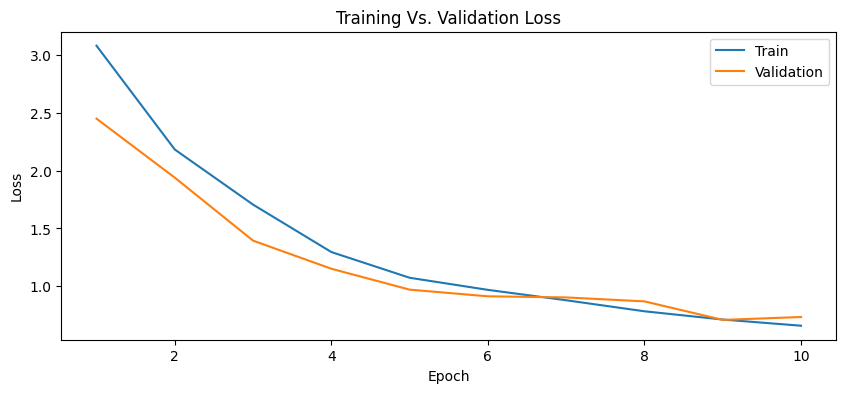

Final Training Loss: 0.6589, Accuracy: 0.7899
Final Validation Loss: 0.7342, Accuracy: 0.7661



TrainingResult(Training_accuracy=0.7898947368421053,
Training_loss=0.658859966453753,
Validation_accuracy=0.7660990712074304,
Validation_loss=0.73423218546268)

In [ ]:
sample_model1 = CropDisease(kernel_size=5).to(device)
# Hyperparameters
hyper_params_sample1 = dict(batch_size=64, num_epochs=10, learning_rate=0.001)
_,dataloaders = get_data_loaders(** hyper_params_sample1)
train_model(sample_model1, dataloaders, ** hyper_params_sample1)

#### (ii) Kernel Size = 3, Batch Size = 64, Learning rate = 0.005

----------
Epoch 1/10
---------- 

train loss: 7.3482, acc: 0.2384
val loss: 2.1764, acc: 0.3709
----------
Epoch 2/10
---------- 

train loss: 1.7956, acc: 0.4681
val loss: 1.6784, acc: 0.4943
----------
Epoch 3/10
---------- 

train loss: 1.5231, acc: 0.5360
val loss: 1.4102, acc: 0.5646
----------
Epoch 4/10
---------- 

train loss: 1.2934, acc: 0.5992
val loss: 1.4129, acc: 0.5515
----------
Epoch 5/10
---------- 

train loss: 1.1929, acc: 0.6299
val loss: 1.2511, acc: 0.6102
----------
Epoch 6/10
---------- 

train loss: 1.1237, acc: 0.6497
val loss: 1.1616, acc: 0.6351
----------
Epoch 7/10
---------- 

train loss: 1.0470, acc: 0.6701
val loss: 1.1110, acc: 0.6498
----------
Epoch 8/10
---------- 

train loss: 0.9933, acc: 0.6852
val loss: 1.1121, acc: 0.6560
----------
Epoch 9/10
---------- 

train loss: 0.9668, acc: 0.6922
val loss: 1.0785, acc: 0.6675
----------
Epoch 10/10
---------- 

train loss: 0.9141, acc: 0.7098
val loss: 1.0514, acc: 0.6689


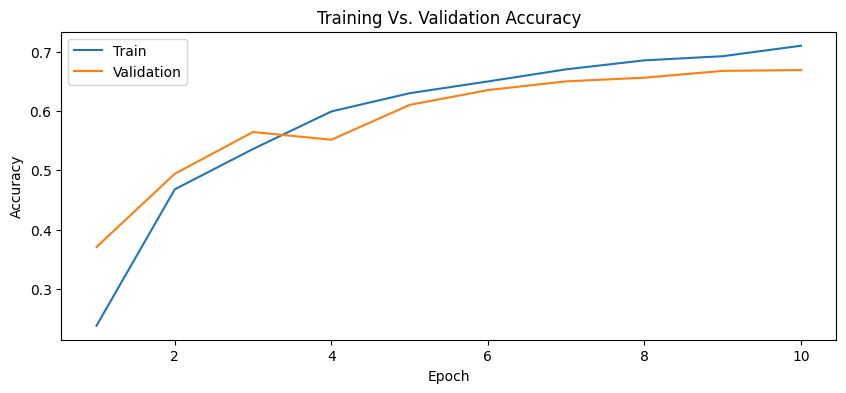

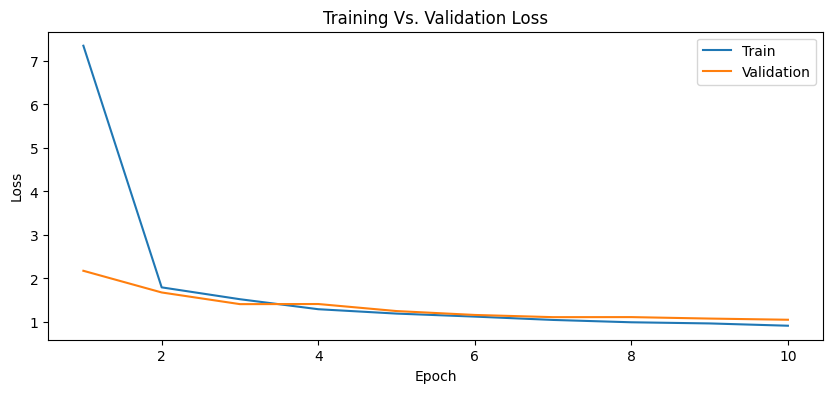

Final Training Loss: 0.9141, Accuracy: 0.7098
Final Validation Loss: 1.0514, Accuracy: 0.6689



TrainingResult(Training_accuracy=0.7098421052631579,
Training_loss=0.9141319348184686,
Validation_accuracy=0.6688854489164087,
Validation_loss=1.0513721667576132)

In [ ]:
sample_model1 = CropDisease(kernel_size=3).to(device)
# Hyperparameters
hyper_params_sample2 = dict(batch_size=64, num_epochs=10, learning_rate=0.005)
_,dataloaders = get_data_loaders(** hyper_params_sample2)
train_model(sample_model1, dataloaders, ** hyper_params_sample2)

#### (iii) Batch Size = 128, Kernel Size = 3

----------
Epoch 1/10
---------- 

train loss: 2.1969, acc: 0.3863
val loss: 1.3985, acc: 0.5740
----------
Epoch 2/10
---------- 

train loss: 1.0133, acc: 0.6819
val loss: 0.8536, acc: 0.7214
----------
Epoch 3/10
---------- 

train loss: 0.6974, acc: 0.7751
val loss: 0.6251, acc: 0.7958
----------
Epoch 4/10
---------- 

train loss: 0.5440, acc: 0.8259
val loss: 0.4810, acc: 0.8483
----------
Epoch 5/10
---------- 

train loss: 0.4269, acc: 0.8597
val loss: 0.4811, acc: 0.8467
----------
Epoch 6/10
---------- 

train loss: 0.3752, acc: 0.8776
val loss: 0.4771, acc: 0.8483
----------
Epoch 7/10
---------- 

train loss: 0.3022, acc: 0.9009
val loss: 0.3522, acc: 0.8892
----------
Epoch 8/10
---------- 

train loss: 0.2901, acc: 0.9053
val loss: 0.3961, acc: 0.8741
----------
Epoch 9/10
---------- 

train loss: 0.2383, acc: 0.9218
val loss: 0.3990, acc: 0.8749
----------
Epoch 10/10
---------- 

train loss: 0.2174, acc: 0.9284
val loss: 0.3442, acc: 0.8921


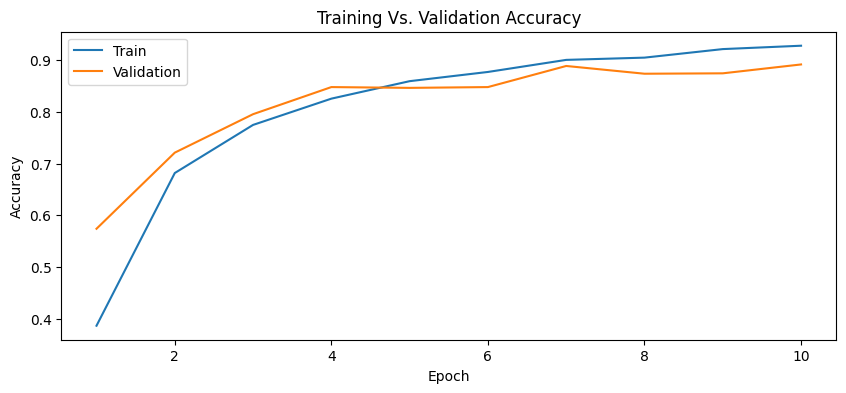

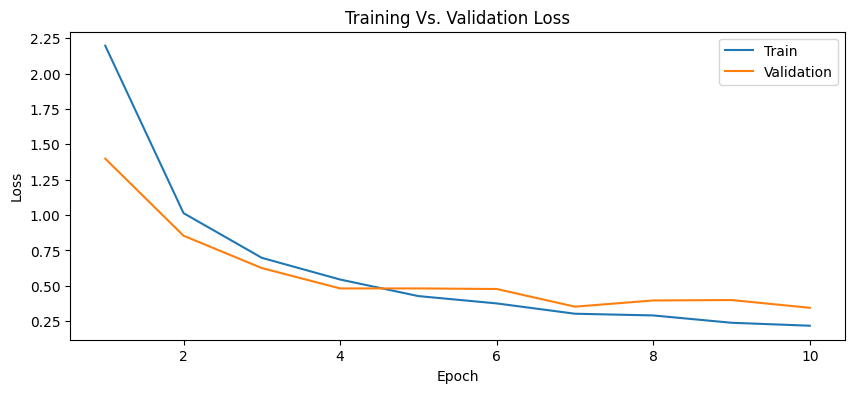

Final Training Loss: 0.2174, Accuracy: 0.9284
Final Validation Loss: 0.3442, Accuracy: 0.8921



TrainingResult(Training_accuracy=0.9283684210526316,
Training_loss=0.21743370979083212,
Validation_accuracy=0.8921052631578948,
Validation_loss=0.34416721594222927)

In [ ]:
sample_model1 = CropDisease(kernel_size=3).to(device)
# Hyperparameters
hyper_params_sample3 = dict(batch_size=128, num_epochs=10, learning_rate=0.001)
_,dataloaders = get_data_loaders(** hyper_params_sample3)
train_model(sample_model1, dataloaders, ** hyper_params_sample3)

#### (iv) Batch Size = 128, Kernel Size = 5

----------
Epoch 1/10
---------- 

train loss: 2.3851, acc: 0.3485
val loss: 1.3562, acc: 0.5862
----------
Epoch 2/10
---------- 

train loss: 0.9913, acc: 0.6956
val loss: 0.7867, acc: 0.7534
----------
Epoch 3/10
---------- 

train loss: 0.6859, acc: 0.7897
val loss: 0.6523, acc: 0.7983
----------
Epoch 4/10
---------- 

train loss: 0.4805, acc: 0.8471
val loss: 0.5293, acc: 0.8339
----------
Epoch 5/10
---------- 

train loss: 0.3973, acc: 0.8702
val loss: 0.5231, acc: 0.8432
----------
Epoch 6/10
---------- 

train loss: 0.3417, acc: 0.8905
val loss: 0.5733, acc: 0.8232
----------
Epoch 7/10
---------- 

train loss: 0.2707, acc: 0.9132
val loss: 0.4340, acc: 0.8700
----------
Epoch 8/10
---------- 

train loss: 0.2293, acc: 0.9229
val loss: 0.3436, acc: 0.8881
----------
Epoch 9/10
---------- 

train loss: 0.1828, acc: 0.9389
val loss: 0.3927, acc: 0.8769
----------
Epoch 10/10
---------- 

train loss: 0.1841, acc: 0.9393
val loss: 0.3376, acc: 0.9000


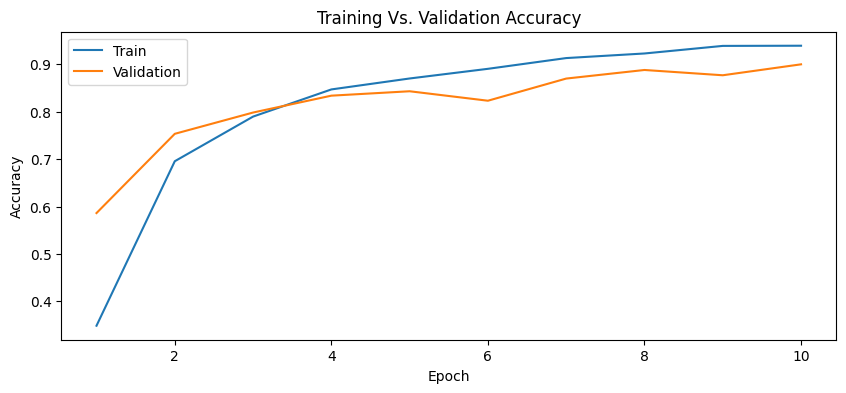

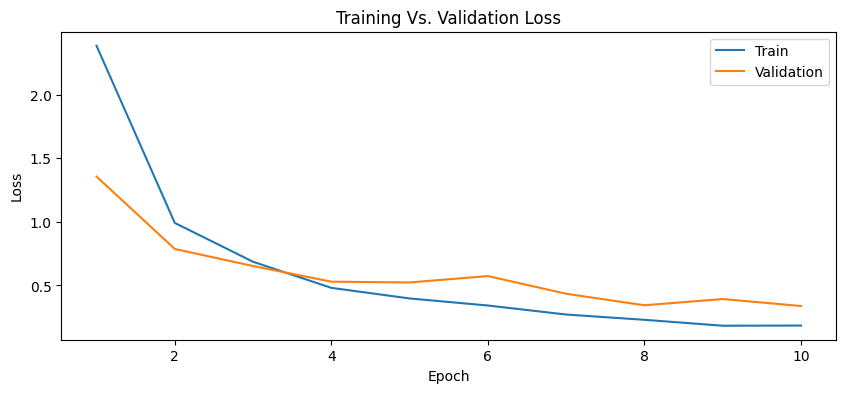

Final Training Loss: 0.1841, Accuracy: 0.9393
Final Validation Loss: 0.3376, Accuracy: 0.9000



TrainingResult(Training_accuracy=0.9392631578947369,
Training_loss=0.18407877691168534,
Validation_accuracy=0.9,
Validation_loss=0.33759214676939664)

In [ ]:
sample_model1 = CropDisease(kernel_size=5).to(device)
# Hyperparameters
hyper_params_sample4 = dict(batch_size=128, num_epochs=10, learning_rate=0.001)
_,dataloaders = get_data_loaders(** hyper_params_sample4)
train_model(sample_model1, dataloaders, ** hyper_params_sample4)

#### (v) Batch Size = 32, Kernel Size = 5

----------
Epoch 1/10
---------- 

train loss: 2.7632, acc: 0.2404
val loss: 2.2545, acc: 0.3395
----------
Epoch 2/10
---------- 

train loss: 1.8590, acc: 0.4366
val loss: 1.9148, acc: 0.4457
----------
Epoch 3/10
---------- 

train loss: 1.3117, acc: 0.5938
val loss: 1.0698, acc: 0.6652
----------
Epoch 4/10
---------- 

train loss: 0.9885, acc: 0.6907
val loss: 1.1375, acc: 0.6481
----------
Epoch 5/10
---------- 

train loss: 0.9468, acc: 0.7115
val loss: 0.7989, acc: 0.7543
----------
Epoch 6/10
---------- 

train loss: 0.6286, acc: 0.8001
val loss: 0.6838, acc: 0.7904
----------
Epoch 7/10
---------- 

train loss: 0.5215, acc: 0.8293
val loss: 0.6670, acc: 0.7924
----------
Epoch 8/10
---------- 

train loss: 0.4597, acc: 0.8531
val loss: 0.6403, acc: 0.8020
----------
Epoch 9/10
---------- 

train loss: 0.4166, acc: 0.8658
val loss: 4.5517, acc: 0.5621
----------
Epoch 10/10
---------- 

train loss: 0.4102, acc: 0.8719
val loss: 0.5624, acc: 0.8395


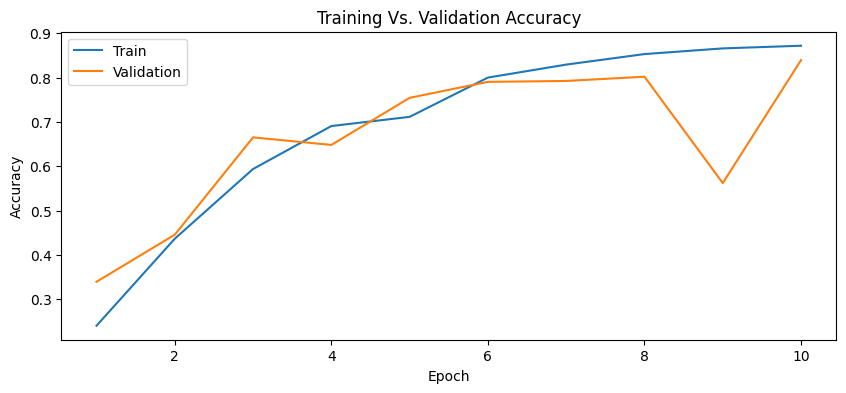

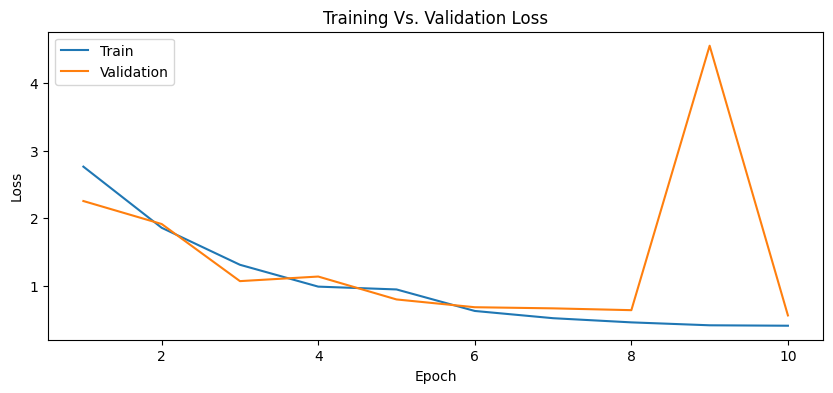

Final Training Loss: 0.4102, Accuracy: 0.8719
Final Validation Loss: 0.5624, Accuracy: 0.8395



TrainingResult(Training_accuracy=0.8718947368421053,
Training_loss=0.4102036586497959,
Validation_accuracy=0.8394736842105264,
Validation_loss=0.5623919649389875)

In [ ]:
sample_model1 = CropDisease(kernel_size=5).to(device)
# Hyperparameters
hyper_params_sample5 = dict(batch_size=32, num_epochs=10, learning_rate=0.001)
_,dataloaders = get_data_loaders(** hyper_params_sample5)
train_model(sample_model1, dataloaders, ** hyper_params_sample5)

----------
Epoch 1/20
---------- 

train loss: 2.1230, acc: 0.3839
val loss: 1.2203, acc: 0.6156
----------
Epoch 2/20
---------- 

train loss: 0.9019, acc: 0.7147
val loss: 0.7653, acc: 0.7515
----------
Epoch 3/20
---------- 

train loss: 0.5942, acc: 0.8078
val loss: 0.6755, acc: 0.7805
----------
Epoch 4/20
---------- 

train loss: 0.4752, acc: 0.8454
val loss: 0.6267, acc: 0.8059
----------
Epoch 5/20
---------- 

train loss: 0.4019, acc: 0.8673
val loss: 0.5441, acc: 0.8262
----------
Epoch 6/20
---------- 

train loss: 0.3224, acc: 0.8928
val loss: 0.3998, acc: 0.8731
----------
Epoch 7/20
---------- 

train loss: 0.2873, acc: 0.9055
val loss: 0.5505, acc: 0.8361
----------
Epoch 8/20
---------- 

train loss: 0.2380, acc: 0.9215
val loss: 0.4014, acc: 0.8724
----------
Epoch 9/20
---------- 

train loss: 0.2260, acc: 0.9274
val loss: 0.4083, acc: 0.8687
----------
Epoch 10/20
---------- 

train loss: 0.1861, acc: 0.9392
val loss: 0.3472, acc: 0.9006
----------
Epoch 11/20
------

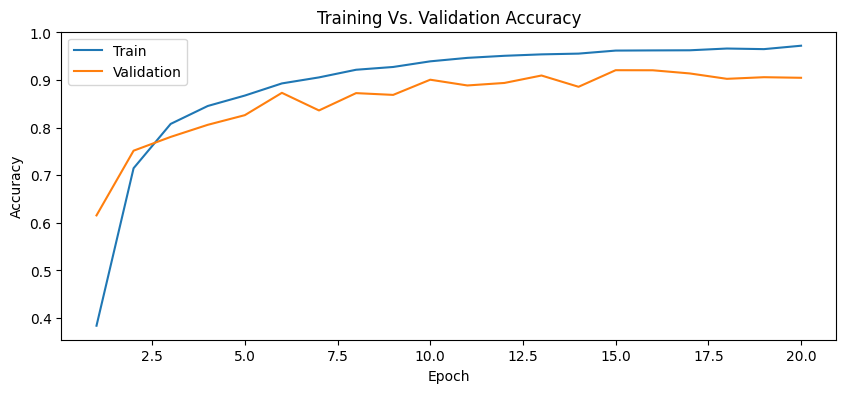

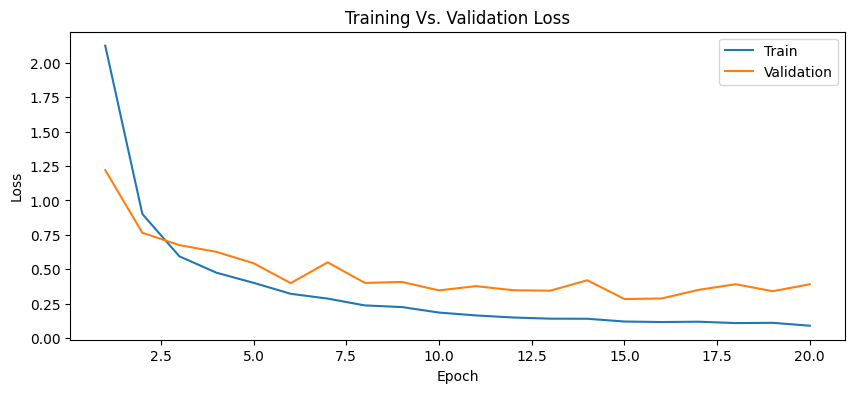

Final Training Loss: 0.0906, Accuracy: 0.9720
Final Validation Loss: 0.3915, Accuracy: 0.9046



TrainingResult(Training_accuracy=0.9720000000000001,
Training_loss=0.09056285179528947,
Validation_accuracy=0.9046439628482973,
Validation_loss=0.39151561250996664)

In [ ]:
best_model = CropDisease().to(device)
hyper_params = dict(batch_size=32, learning_rate=0.001, num_epochs= 20)
_, dataloaders = get_data_loaders(** hyper_params)
train_model(best_model, dataloaders, ** hyper_params)

Based on the hyperparameter tuning, the optimal results were obtained with a kernel size of 3, a batch size of 32, 15 epochs, and a learning rate of 0.001. The training and validation accuracies achieved were 96.18% and 92.06%, respectively.

## **ResNet**

The 'Resnet50' class implements transfer learning by leveraging a pre-trained ResNet-50 model. The pre-trained ResNet-50 is loaded and its parameters are frozen to retain the learned features. The fully-connected layer of the original ResNet-50 is replaced with a customized one to adapt the model for a specific classification task with a different number of output classes. This approach accelerates training and enhances performance by utilizing knowledge gained from training on a large dataset for a similar task (Crop Disease Identification).

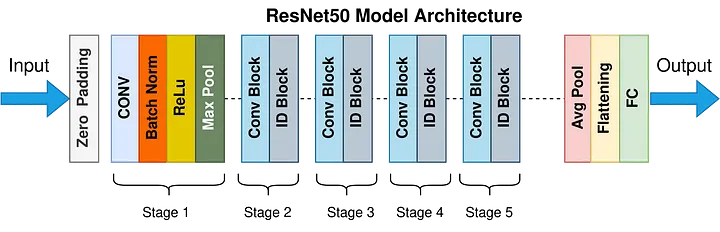

In [15]:
class Resnet50(nn.Module):
  def __init__(self, num_classes, device):
    super(Resnet50, self).__init__()
    self.name = "Resnet50"
    self.resnet = models.resnet50(pretrained=True).to(device)   # Loading the pre-trained Resnet50 model
    for param in self.resnet.parameters():
      param.requires_grad = False                               # Freezing the parameters
    self.resnet.fc = nn.Sequential(                             # Modifying the fully-connected layer
                      nn.Linear(2048, 512),
                      nn.ReLU(inplace=True),
                      nn.Linear(512, num_classes)).to(device)

  def forward(self, x):
    x = self.resnet(x)
    return x

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 94.2MB/s]


----------
Epoch 1/10
---------- 

train loss: 0.8808, acc: 0.7603
val loss: 0.3628, acc: 0.8864
----------
Epoch 2/10
---------- 

train loss: 0.3546, acc: 0.8864
val loss: 0.3111, acc: 0.8981
----------
Epoch 3/10
---------- 

train loss: 0.3106, acc: 0.8983
val loss: 0.3007, acc: 0.8978
----------
Epoch 4/10
---------- 

train loss: 0.2729, acc: 0.9094
val loss: 0.2784, acc: 0.9099
----------
Epoch 5/10
---------- 

train loss: 0.2532, acc: 0.9174
val loss: 0.3387, acc: 0.8890
----------
Epoch 6/10
---------- 

train loss: 0.2307, acc: 0.9232
val loss: 0.2112, acc: 0.9316
----------
Epoch 7/10
---------- 

train loss: 0.2135, acc: 0.9282
val loss: 0.2260, acc: 0.9223
----------
Epoch 8/10
---------- 

train loss: 0.2106, acc: 0.9305
val loss: 0.2278, acc: 0.9254
----------
Epoch 9/10
---------- 

train loss: 0.1989, acc: 0.9308
val loss: 0.2120, acc: 0.9314
----------
Epoch 10/10
---------- 

train loss: 0.1935, acc: 0.9343
val loss: 0.2596, acc: 0.9167


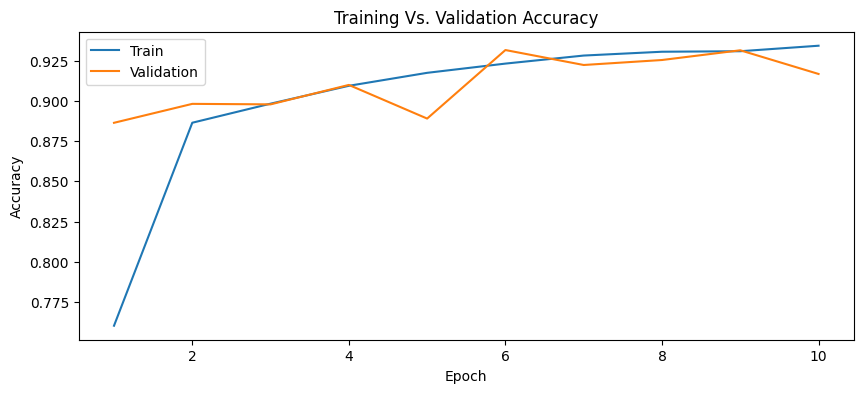

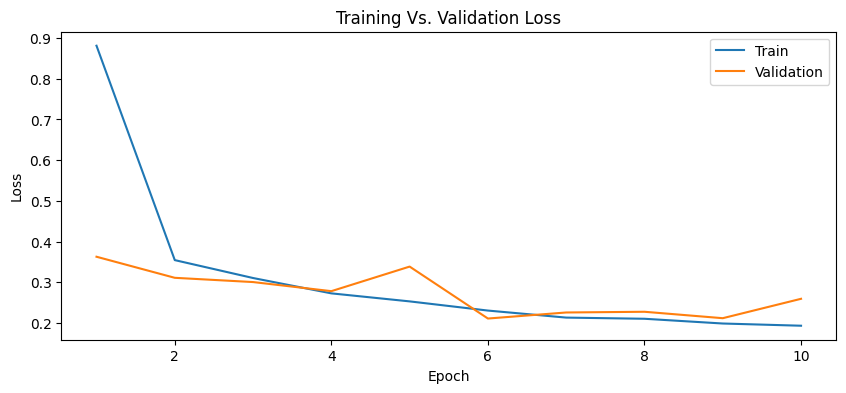

Final Training Loss: 0.1935, Accuracy: 0.9343
Final Validation Loss: 0.2596, Accuracy: 0.9167



TrainingResult(Training_accuracy=0.9342631578947369,
Training_loss=0.19350572321132609,
Validation_accuracy=0.91671826625387,
Validation_loss=0.25959972080431487)

In [ ]:
resnet = Resnet50(num_classes, device).to(device)
hyper_params = dict(batch_size=32, learning_rate=0.001, num_epochs= 10)
_, dataloaders = get_data_loaders(** hyper_params)
train_model(resnet, dataloaders, ** hyper_params)

In the process of transfer learning with the ResNet50 model, we attained a training accuracy of 92.32% and a validation accuracy of 93.16%.  

## **AlexNet**

The 'AlexNet' class implements transfer learning by utilizing a pre-trained AlexNet model. The classifier layers of the original AlexNet are modified to adapt the model for a specific classification task with a different number of output classes.

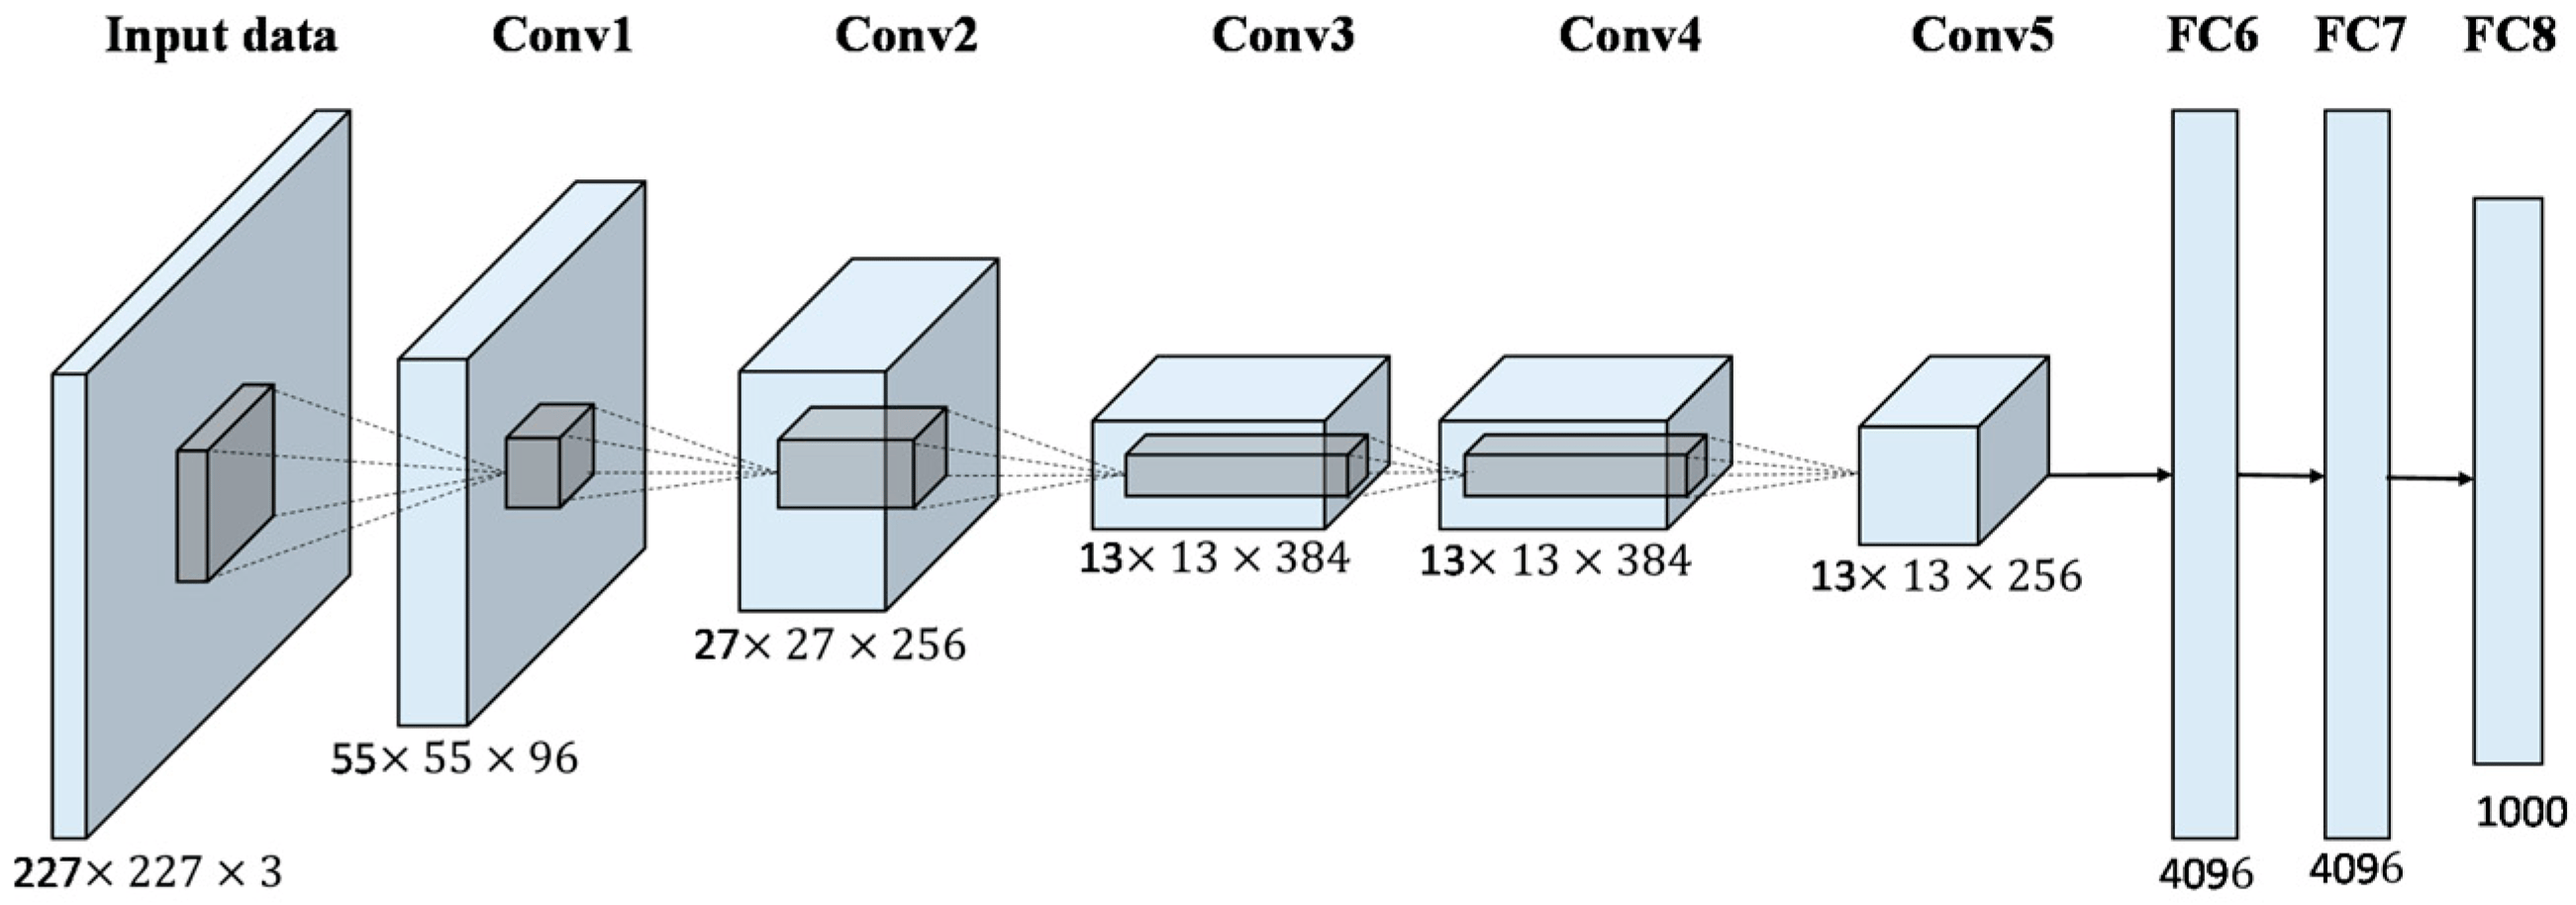

In [16]:
class AlexNet(nn.Module):
  def __init__(self, num_classes, device):
    super(AlexNet, self).__init__()
    self.name = "AlexNet"
    self.alexnet = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True).to(device)  # Loading the pre-trained alexnet model
    for param in self.alexnet.parameters():
      param.requires_grad = False                            # Freezing the parameters
    self.alexnet.classifier[4] = nn.Linear(4096, 1024)       # Modifying the classifier
    self.alexnet.classifier[6] = nn.Linear(1024, num_classes)

  def forward(self, x):
    x = self.alexnet(x)
    return x

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 97.0MB/s]


----------
Epoch 1/10
---------- 

train loss: 0.8918, acc: 0.7300
val loss: 0.3728, acc: 0.8788
----------
Epoch 2/10
---------- 

train loss: 0.5753, acc: 0.8201
val loss: 0.3448, acc: 0.8907
----------
Epoch 3/10
---------- 

train loss: 0.5161, acc: 0.8346
val loss: 0.2792, acc: 0.9101
----------
Epoch 4/10
---------- 

train loss: 0.4827, acc: 0.8464
val loss: 0.3178, acc: 0.8955
----------
Epoch 5/10
---------- 

train loss: 0.4666, acc: 0.8516
val loss: 0.2795, acc: 0.9079
----------
Epoch 6/10
---------- 

train loss: 0.4455, acc: 0.8596
val loss: 0.3089, acc: 0.9012
----------
Epoch 7/10
---------- 

train loss: 0.4341, acc: 0.8657
val loss: 0.2800, acc: 0.9136
----------
Epoch 8/10
---------- 

train loss: 0.4244, acc: 0.8668
val loss: 0.2945, acc: 0.9068
----------
Epoch 9/10
---------- 

train loss: 0.4107, acc: 0.8697
val loss: 0.2772, acc: 0.9223
----------
Epoch 10/10
---------- 

train loss: 0.4057, acc: 0.8761
val loss: 0.2857, acc: 0.9118


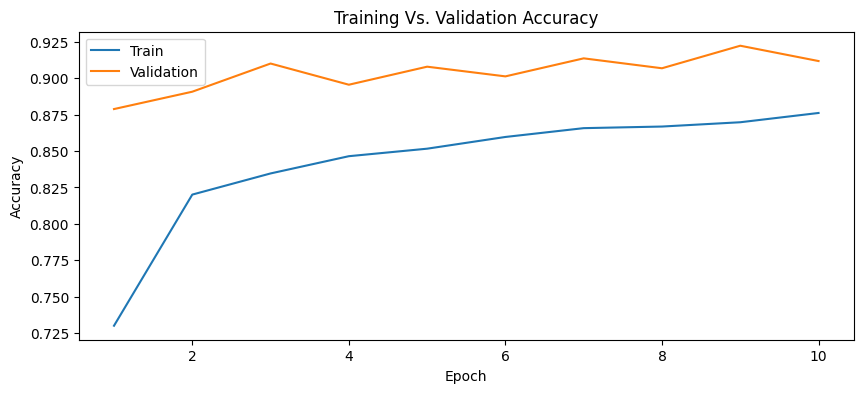

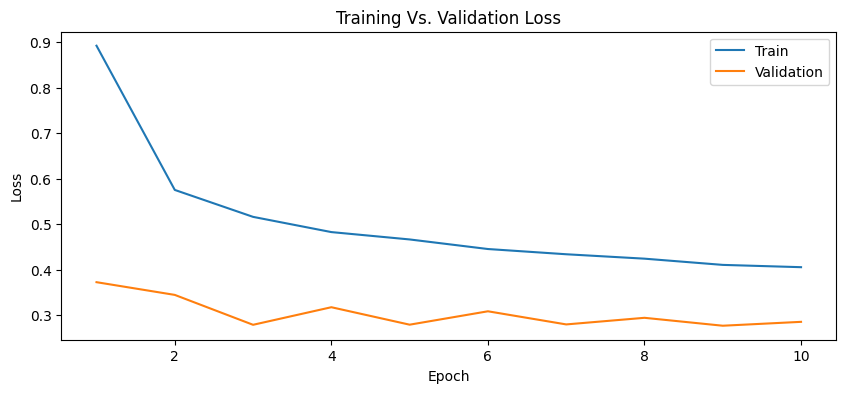

Final Training Loss: 0.4057, Accuracy: 0.8761
Final Validation Loss: 0.2857, Accuracy: 0.9118



TrainingResult(Training_accuracy=0.8761052631578948,
Training_loss=0.4056711283828083,
Validation_accuracy=0.911764705882353,
Validation_loss=0.2856959927977054)

In [ ]:
alexnet_model = AlexNet(num_classes, device).to(device)
hyper_params = dict(batch_size=32, learning_rate=0.001, num_epochs=10)
_, dataloaders = get_data_loaders(**hyper_params)
train_model(alexnet_model, dataloaders, **hyper_params)

While using transfer learning with the AlexNet model, we achieved a training accuracy of 86.97% and a validation accuracy of 92.23%.

## **VGG19**

The 'VGG19' class uses transfer learning with a pre-trained VGG-19 model. We load the pre-trained VGG-19 and keep its knowledge intact by freezing its parameters. To make it work for our specific task, we change the last fully connected layer in the original VGG-19 classifier.

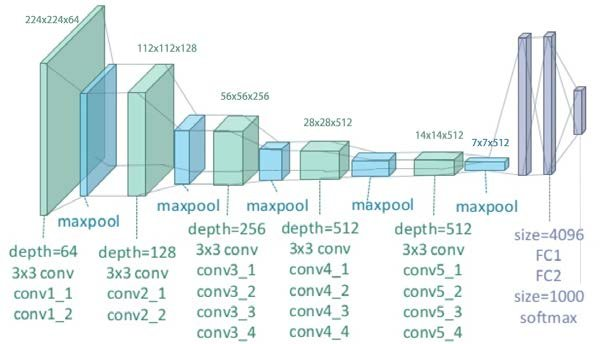

In [17]:
class VGG19(nn.Module):
  def __init__(self, num_classes, device):
    super(VGG19, self).__init__()
    self.name = "VGG19"
    self.vgg = models.vgg19(pretrained=True).to(device)                # Loading the pre-trained VGG-16 model
    for param in self.vgg.parameters():
      param.requires_grad = False                                      # Freezing the parameters
    self.vgg.classifier[-1] = nn.Linear(4096, num_classes).to(device)  # Modifying the last fully connected layer

  def forward(self, x):
    x = self.vgg(x)
    return x

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 141MB/s]


----------
Epoch 1/10
---------- 

train loss: 1.3008, acc: 0.6212
val loss: 0.7880, acc: 0.7557
----------
Epoch 2/10
---------- 

train loss: 0.8976, acc: 0.7198
val loss: 0.6359, acc: 0.8059
----------
Epoch 3/10
---------- 

train loss: 0.8652, acc: 0.7317
val loss: 0.6061, acc: 0.8057
----------
Epoch 4/10
---------- 

train loss: 0.8581, acc: 0.7346
val loss: 0.5788, acc: 0.8178
----------
Epoch 5/10
---------- 

train loss: 0.8296, acc: 0.7463
val loss: 0.5319, acc: 0.8331
----------
Epoch 6/10
---------- 

train loss: 0.8166, acc: 0.7487
val loss: 0.5387, acc: 0.8319
----------
Epoch 7/10
---------- 

train loss: 0.8390, acc: 0.7448
val loss: 0.5535, acc: 0.8282
----------
Epoch 8/10
---------- 

train loss: 0.8171, acc: 0.7552
val loss: 0.5658, acc: 0.8207
----------
Epoch 9/10
---------- 

train loss: 0.8178, acc: 0.7554
val loss: 0.5655, acc: 0.8320
----------
Epoch 10/10
---------- 

train loss: 0.8114, acc: 0.7599
val loss: 0.5349, acc: 0.8348


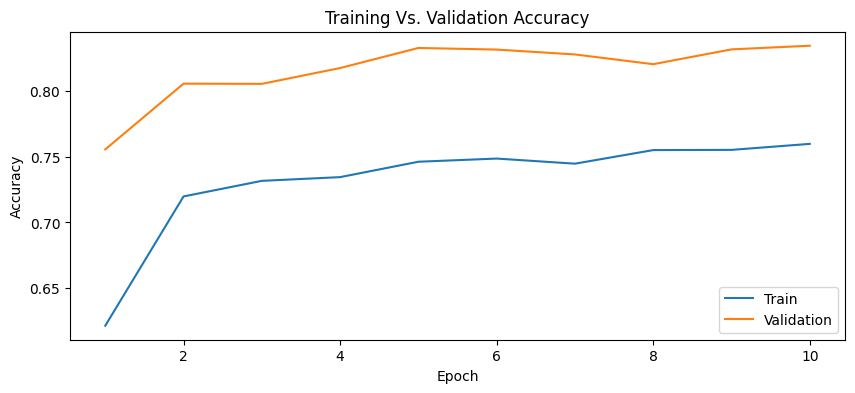

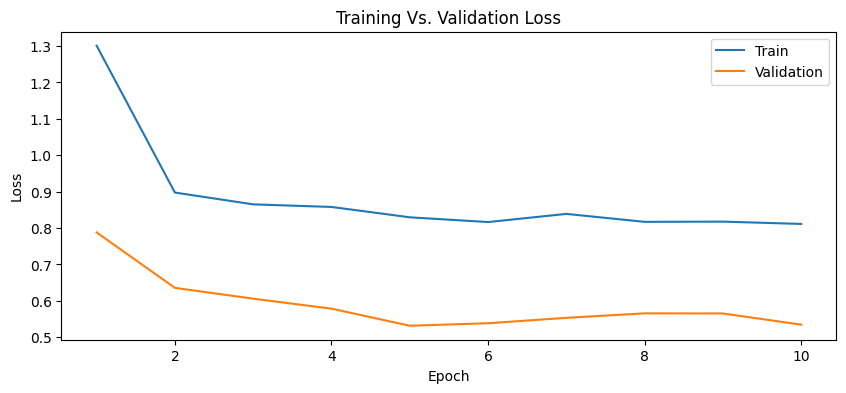

Final Training Loss: 0.8114, Accuracy: 0.7599
Final Validation Loss: 0.5349, Accuracy: 0.8348



TrainingResult(Training_accuracy=0.7599473684210527,
Training_loss=0.8114046888602408,
Validation_accuracy=0.8348297213622291,
Validation_loss=0.5348811700986266)

In [ ]:
vgg19 = VGG19(num_classes, device).to(device)
hyper_params = dict(batch_size=32, learning_rate=0.001, num_epochs= 10)
_, dataloaders = get_data_loaders(** hyper_params)
train_model(vgg19, dataloaders, **hyper_params)

During the application of transfer learning with the VGG19 model, we obtained a training accuracy of 75.99% and a validation accuracy of 83.48%.

## **GoogLeNet**

The 'GoogLeNet' class employs transfer learning by making use of a pre-trained GoogLeNet model. We load the pre-trained GoogLeNet and freeze its parameters to preserve the learned features. To tailor the model for a particular classification task with a different number of output classes, we modify the fully connected layer of the original GoogLeNet

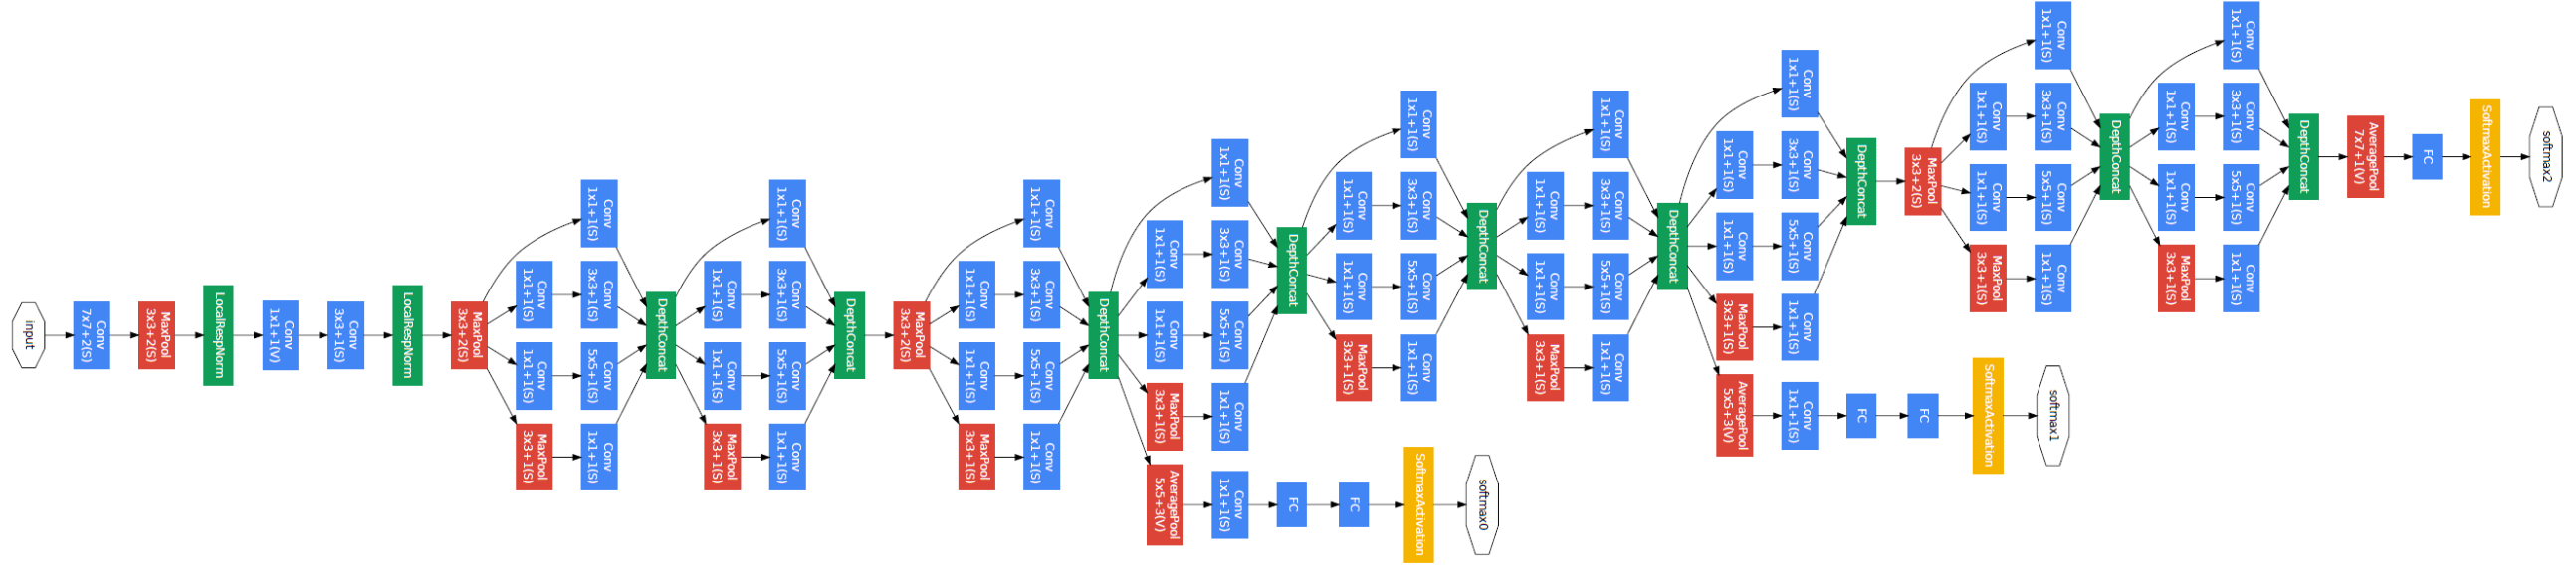

In [ ]:
def googlenet_dataloaders(batch_size: 32, **kwargs):

  train_dataset_path = '/content/dataset/Dataset/Train'
  val_dataset_path = '/content/dataset/Dataset/Valid'
  test_dataset_path = '/content/dataset/Dataset/Test'

  mean = [0.485, 0.456, 0.406] #Commonly used values for RGB channels
  std = [0.229, 0.224, 0.225] #Commonly used values for RGB channels

  # Data Transforms
  data_transforms = {
      'train':
        transforms.Compose([
        transforms.Resize((299,299)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ]),
      'val':
        transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ]),
      'test':
        transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])
        }

  # Image Datasets
  image_datasets = {
                    'train': ImageFolder(train_dataset_path, data_transforms['train']),
                    'val': ImageFolder(val_dataset_path, data_transforms['val']),
                    'test': ImageFolder(test_dataset_path, data_transforms['test'])
                   }

  # Dataloaders
  dataloaders = {
                'train': DataLoader(image_datasets['train'],
                                    batch_size= batch_size,
                                    shuffle=True,
                                    num_workers=1),
                'val': DataLoader(image_datasets['val'],
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=1),
                'test': DataLoader(image_datasets['test'],
                                   batch_size=batch_size,
                                   shuffle=False,
                                   num_workers=1)
                }

  return image_datasets, dataloaders

In [18]:
class GoogLeNet(nn.Module):
  def __init__(self, num_classes, device):
    super(GoogLeNet, self).__init__()
    self.name = "GoogLeNet"
    self.googlenet = models.googlenet(pretrained=True).to(device)  # Loading the pre-trained GoogLeNet model
    for param in self.googlenet.parameters():
      param.requires_grad = False                                  # Freezing the parameters
    self.googlenet.fc = nn.Linear(1024, num_classes).to(device)    # Modifying the fully connected layer

  def forward(self, x):
    x = self.googlenet(x)
    return x

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 104MB/s]


----------
Epoch 1/10
---------- 

train loss: 1.7095, acc: 0.6823
val loss: 0.8524, acc: 0.8522
----------
Epoch 2/10
---------- 

train loss: 0.6813, acc: 0.8633
val loss: 0.5593, acc: 0.8763
----------
Epoch 3/10
---------- 

train loss: 0.4963, acc: 0.8836
val loss: 0.4304, acc: 0.9003
----------
Epoch 4/10
---------- 

train loss: 0.4152, acc: 0.8996
val loss: 0.3608, acc: 0.9133
----------
Epoch 5/10
---------- 

train loss: 0.3587, acc: 0.9079
val loss: 0.3276, acc: 0.9146
----------
Epoch 6/10
---------- 

train loss: 0.3273, acc: 0.9141
val loss: 0.2929, acc: 0.9238
----------
Epoch 7/10
---------- 

train loss: 0.3055, acc: 0.9189
val loss: 0.2676, acc: 0.9286
----------
Epoch 8/10
---------- 

train loss: 0.2924, acc: 0.9203
val loss: 0.2482, acc: 0.9311
----------
Epoch 9/10
---------- 

train loss: 0.2726, acc: 0.9244
val loss: 0.2386, acc: 0.9342
----------
Epoch 10/10
---------- 

train loss: 0.2601, acc: 0.9276
val loss: 0.2399, acc: 0.9324


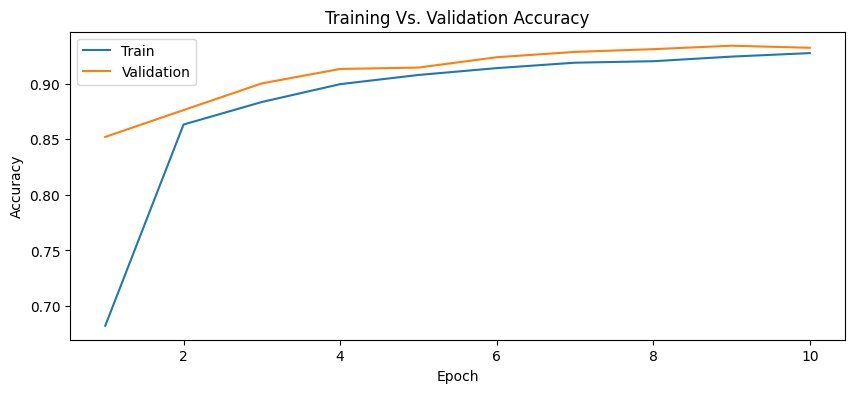

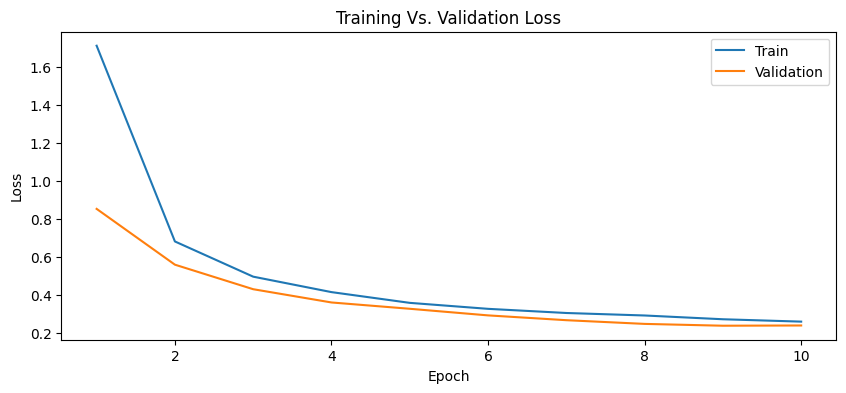

Final Training Loss: 0.2601, Accuracy: 0.9276
Final Validation Loss: 0.2399, Accuracy: 0.9324



TrainingResult(Training_accuracy=0.9275789473684211,
Training_loss=0.2601238895591937,
Validation_accuracy=0.9323529411764706,
Validation_loss=0.23990228938244446)

In [ ]:
googlenet_model = GoogLeNet(num_classes, device).to(device)
hyper_params = dict(batch_size=128, learning_rate=0.0015, num_epochs= 10)
_, dataloaders = googlenet_dataloaders(** hyper_params)
train_model(googlenet_model, dataloaders, **hyper_params)

While employing transfer learning with the GoogLeNet model, we achieved a training accuracy of 92.44% and a validation accuracy of 93.42%.

##**Hybrid Model**

The 'Hybrid' class is a model that works like a team, bringing together predictions from four separate pre-trained neural networks: ResNet, AlexNet, VGG19, and GoogLeNet. Each of these models processes the input, and their results are joined together along a special dimension. The combined feature representation is then fed into a linear layer to produce the final output for the ensemble. This hybrid model aims to leverage diverse features captured by each base model, potentially improving overall performance and robustness across different aspects of the input data.

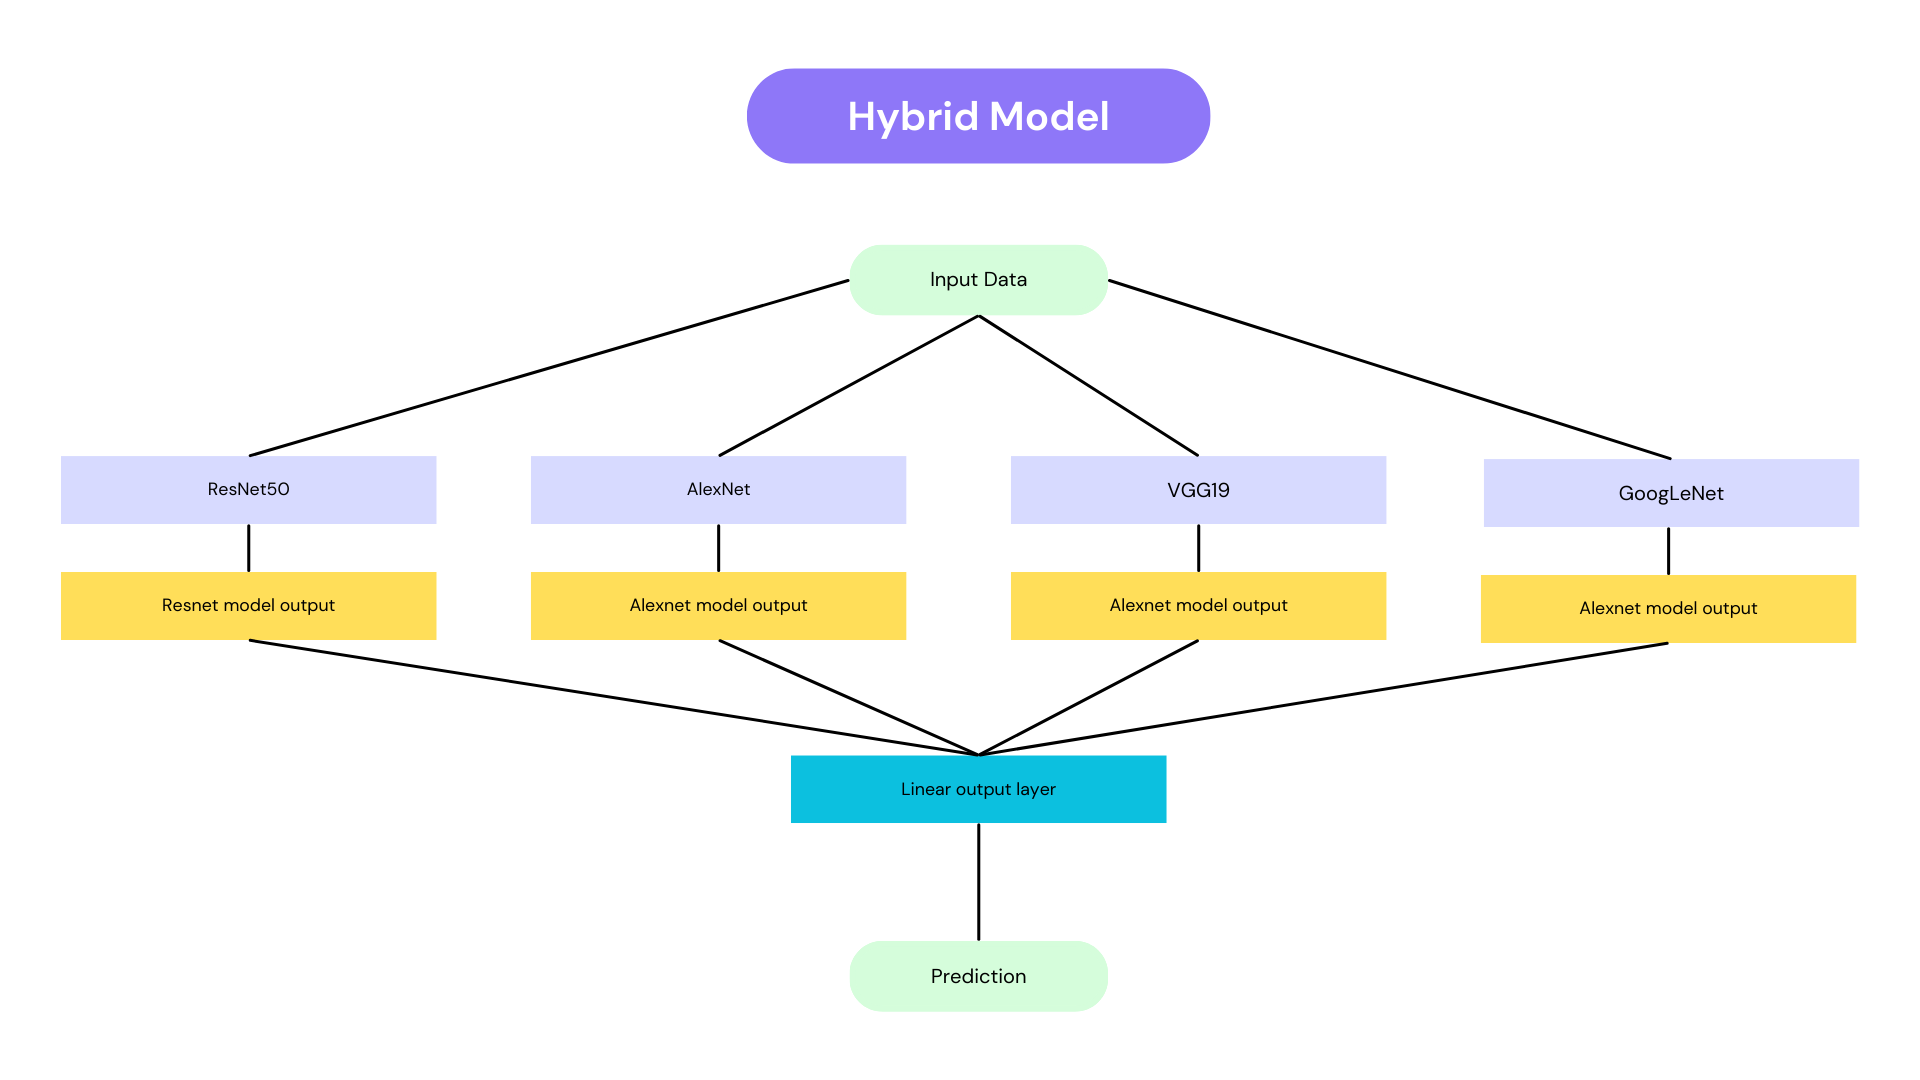

In [19]:
class Hybrid(nn.Module):
  def __init__(self, resnet, alexnet, vgg19, googlenet):
    super(Hybrid, self).__init__()
    self.name = "Hybrid"
    self.resnet = resnet
    self.alexnet = alexnet
    self.vgg19 = vgg19
    self.googlenet = googlenet

    # Output layer for the Hybrid model
    self.output_layer = nn.Linear(4 * num_classes, num_classes)

  def forward(self, x):
    # Resizing input to match GoogLeNet's input size (299x299)
    x_googlenet = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

    # Forward pass for each model
    out_resnet = self.resnet(x)
    out_alexnet = self.alexnet(x)
    out_vgg19 = self.vgg19(x)
    out_googlenet = self.googlenet(x_googlenet)

    ensemble_output = torch.cat((out_resnet, out_alexnet, out_vgg19, out_googlenet), dim=1)
    output = self.output_layer(ensemble_output)

    return ensemble_output


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


----------
Epoch 1/10
---------- 

train loss: 0.8999, acc: 0.7555
val loss: 0.4399, acc: 0.8570
----------
Epoch 2/10
---------- 

train loss: 0.3696, acc: 0.8818
val loss: 0.3155, acc: 0.8955
----------
Epoch 3/10
---------- 

train loss: 0.2962, acc: 0.9031
val loss: 0.2850, acc: 0.9102
----------
Epoch 4/10
---------- 

train loss: 0.2640, acc: 0.9120
val loss: 0.2788, acc: 0.9104
----------
Epoch 5/10
---------- 

train loss: 0.2405, acc: 0.9208
val loss: 0.2724, acc: 0.9076
----------
Epoch 6/10
---------- 

train loss: 0.2319, acc: 0.9226
val loss: 0.2182, acc: 0.9285
----------
Epoch 7/10
---------- 

train loss: 0.2203, acc: 0.9263
val loss: 0.2066, acc: 0.9311
----------
Epoch 8/10
---------- 

train loss: 0.2048, acc: 0.9319
val loss: 0.2349, acc: 0.9257
----------
Epoch 9/10
---------- 

train loss: 0.2036, acc: 0.9304
val loss: 0.2221, acc: 0.9297
----------
Epoch 10/10
---------- 

train loss: 0.1861, acc: 0.9355
val loss: 0.2247, acc: 0.9317


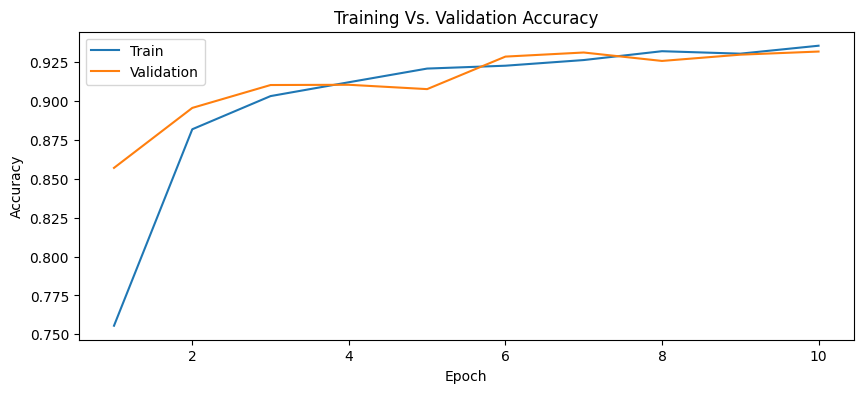

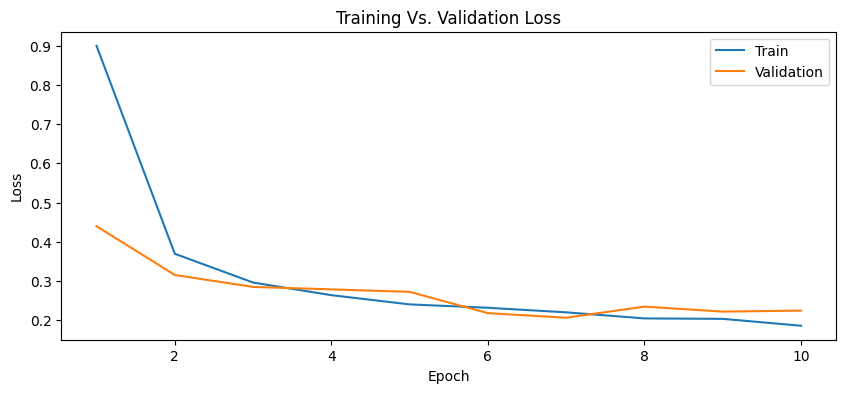

Final Training Loss: 0.1861, Accuracy: 0.9355
Final Validation Loss: 0.2247, Accuracy: 0.9317



TrainingResult(Training_accuracy=0.9354736842105263,
Training_loss=0.1861387027031497,
Validation_accuracy=0.931733746130031,
Validation_loss=0.22470865944867532)

In [ ]:
resnet_model = Resnet50(num_classes, device).to(device)
alexnet_model = AlexNet(num_classes, device).to(device)
vgg19_model = VGG19(num_classes, device).to(device)
googlenet_model = GoogLeNet(num_classes, device).to(device)


hybrid_model = Hybrid(resnet_model, alexnet_model, vgg19_model, googlenet_model).to(device)

hyper_params_hybrid = dict(batch_size=32, learning_rate=0.001, num_epochs=10)
_, dataloaders_hybrid = get_data_loaders(**hyper_params_hybrid)
train_model(hybrid_model, dataloaders_hybrid, **hyper_params_hybrid)

For the transfer learning with the Hybrid model, we achieved a training accuracy of 93.55% and a validation accuracy of 93.17%.

The 'Hybrid_1' resembles the Hybrid model, but with a change in the lineup of models. In this version, the models employed are ResNet, AlexNet, CNN (CropDisease), and GoogLeNet.

In [20]:
class Hybrid_1(nn.Module):
  def __init__(self, resnet, alexnet, cnn, googlenet):
    super(Hybrid_1, self).__init__()
    self.name = "Hybrid_1"
    self.resnet = resnet
    self.alexnet = alexnet
    self.cnn = cnn
    self.googlenet = googlenet

    # Output layer for the Hybrid model
    self.output_layer = nn.Linear(4 * num_classes, num_classes)

  def forward(self, x):
    # Resizing input to match GoogLeNet's input size (299x299)
    x_googlenet = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

    # Forward pass for each model
    out_resnet = self.resnet(x)
    out_alexnet = self.alexnet(x)
    out_cnn = self.cnn(x)
    out_googlenet = self.googlenet(x_googlenet)

    ensemble_output = torch.cat((out_resnet, out_alexnet, out_cnn, out_googlenet), dim=1)
    output = self.output_layer(ensemble_output)

    return ensemble_output


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


----------
Epoch 1/10
---------- 

train loss: 0.8996, acc: 0.7545
val loss: 0.4272, acc: 0.8619
----------
Epoch 2/10
---------- 

train loss: 0.3704, acc: 0.8783
val loss: 0.3467, acc: 0.8824
----------
Epoch 3/10
---------- 

train loss: 0.3070, acc: 0.8999
val loss: 0.2816, acc: 0.9065
----------
Epoch 4/10
---------- 

train loss: 0.2667, acc: 0.9124
val loss: 0.2784, acc: 0.9127
----------
Epoch 5/10
---------- 

train loss: 0.2474, acc: 0.9182
val loss: 0.2115, acc: 0.9245
----------
Epoch 6/10
---------- 

train loss: 0.2349, acc: 0.9238
val loss: 0.2100, acc: 0.9285
----------
Epoch 7/10
---------- 

train loss: 0.2235, acc: 0.9257
val loss: 0.2283, acc: 0.9235
----------
Epoch 8/10
---------- 

train loss: 0.2093, acc: 0.9265
val loss: 0.2176, acc: 0.9345
----------
Epoch 9/10
---------- 

train loss: 0.2008, acc: 0.9314
val loss: 0.1965, acc: 0.9324
----------
Epoch 10/10
---------- 

train loss: 0.1887, acc: 0.9360
val loss: 0.2298, acc: 0.9246


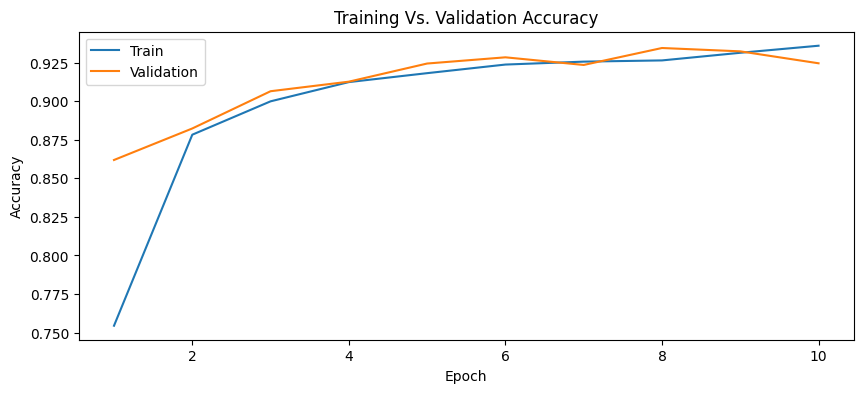

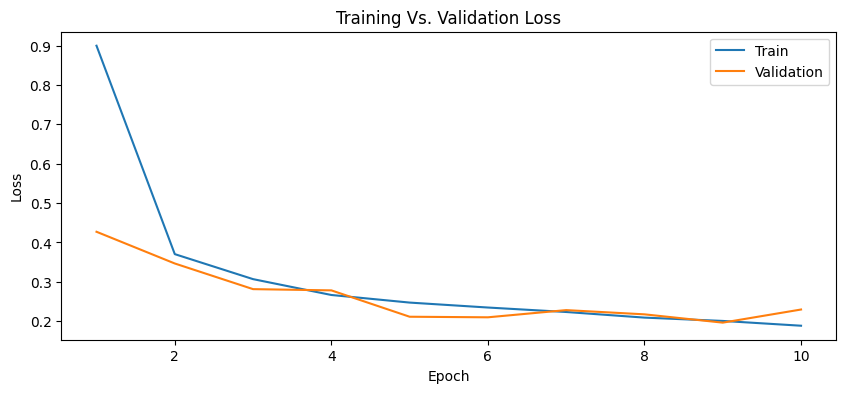

Final Training Loss: 0.1887, Accuracy: 0.9360
Final Validation Loss: 0.2298, Accuracy: 0.9246



TrainingResult(Training_accuracy=0.936,
Training_loss=0.18866384734762343,
Validation_accuracy=0.9246130030959753,
Validation_loss=0.22982127215747863)

In [ ]:
resnet_model = Resnet50(num_classes, device).to(device)
alexnet_model = AlexNet(num_classes, device).to(device)
cnn_model = CropDisease().to(device)
googlenet_model = GoogLeNet(num_classes, device).to(device)

hybrid_model_1 = Hybrid_1(resnet_model, alexnet_model, cnn_model, googlenet_model).to(device)

hyper_params_hybrid = dict(batch_size=32, learning_rate=0.001, num_epochs=10)
_, dataloaders_hybrid = get_data_loaders(**hyper_params_hybrid)
train_model(hybrid_model_1, dataloaders_hybrid, **hyper_params_hybrid)

While transfer learning with the Hybrid_1 model, we achieved a training accuracy of 92.65% and a validation accuracy of 93.45%.

##**Ensemble Model**

The 'EnsembleModel' class represents a ensemble model that merges predictions from three distinct pre-trained neural networks: ResNet, AlexNet, and GoogLeNet. Each of these models processes the input, and their predictions are combined through a majority voting approach. The class employs the mode function to identify the most frequently predicted class across the ensemble. This method yields a consolidated and potentially more robust prediction by considering the collective insights of the individual models.

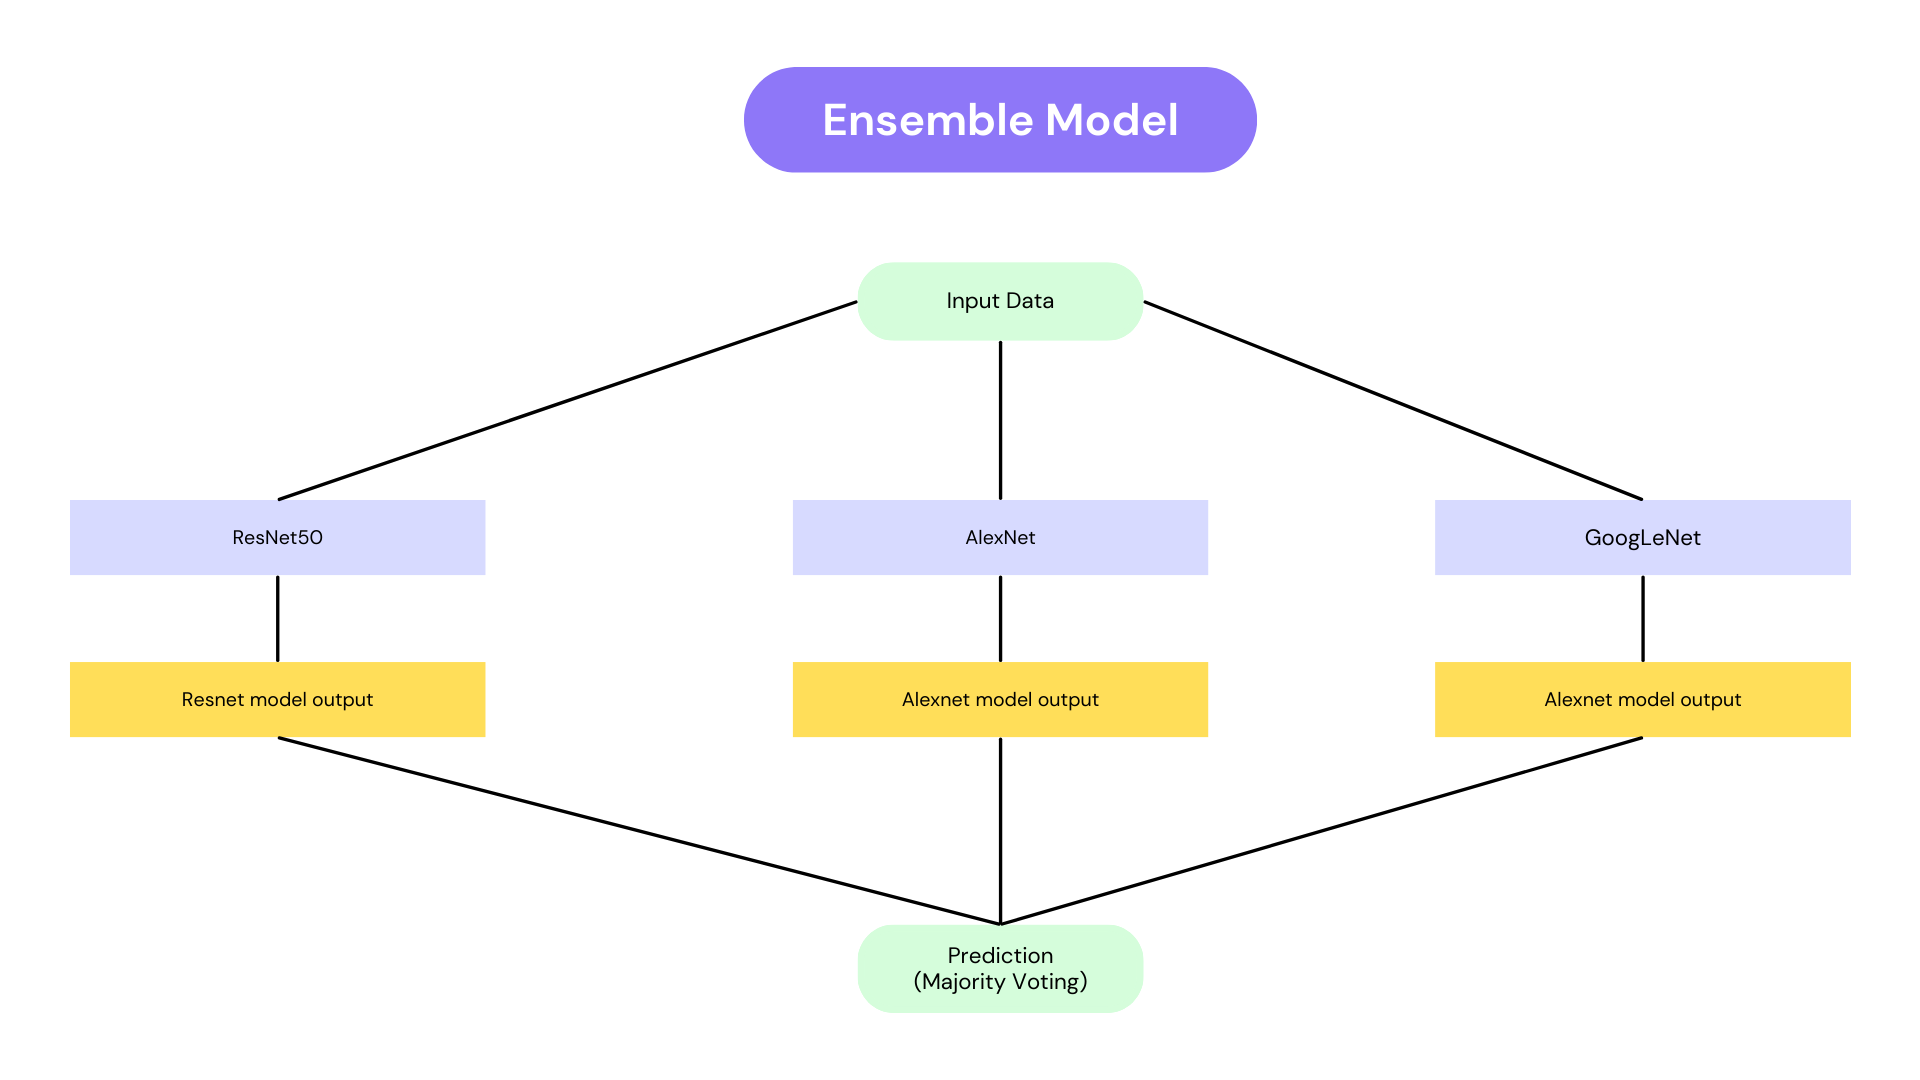

In [21]:
class EnsembleModel(nn.Module):
    def __init__(self, resnet, alexnet, googlenet):
        super(EnsembleModel, self).__init__()
        self.name = "Ensemble"
        self.resnet = resnet
        self.alexnet = alexnet
        self.googlenet = googlenet

    def forward(self, x):
        # Resizing input to match GoogLeNet's input size (299x299)
        x_googlenet = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        # Forward pass for each model
        out_resnet = self.resnet(x)
        out_alexnet = self.alexnet(x)
        out_googlenet = self.googlenet(x_googlenet)

        # Combining predictions using majority voting
        ensemble_predictions = torch.mode(
            torch.stack([out_resnet, out_alexnet, out_googlenet], dim=1), dim=1
        ).values.squeeze()

        return ensemble_predictions

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


----------
Epoch 1/10
---------- 

train loss: 1.0860, acc: 0.6959
val loss: 0.4993, acc: 0.8495
----------
Epoch 2/10
---------- 

train loss: 0.5190, acc: 0.8421
val loss: 0.3644, acc: 0.8861
----------
Epoch 3/10
---------- 

train loss: 0.4236, acc: 0.8703
val loss: 0.3121, acc: 0.9000
----------
Epoch 4/10
---------- 

train loss: 0.3734, acc: 0.8845
val loss: 0.2579, acc: 0.9193
----------
Epoch 5/10
---------- 

train loss: 0.3383, acc: 0.8945
val loss: 0.3237, acc: 0.8995
----------
Epoch 6/10
---------- 

train loss: 0.3138, acc: 0.9022
val loss: 0.2229, acc: 0.9307
----------
Epoch 7/10
---------- 

train loss: 0.2904, acc: 0.9086
val loss: 0.2496, acc: 0.9187
----------
Epoch 8/10
---------- 

train loss: 0.2602, acc: 0.9172
val loss: 0.2388, acc: 0.9226
----------
Epoch 9/10
---------- 

train loss: 0.2736, acc: 0.9154
val loss: 0.2385, acc: 0.9248
----------
Epoch 10/10
---------- 

train loss: 0.2489, acc: 0.9219
val loss: 0.2035, acc: 0.9333


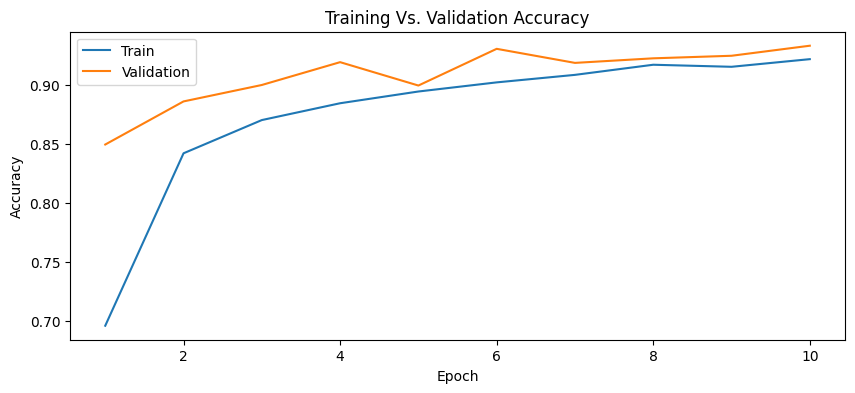

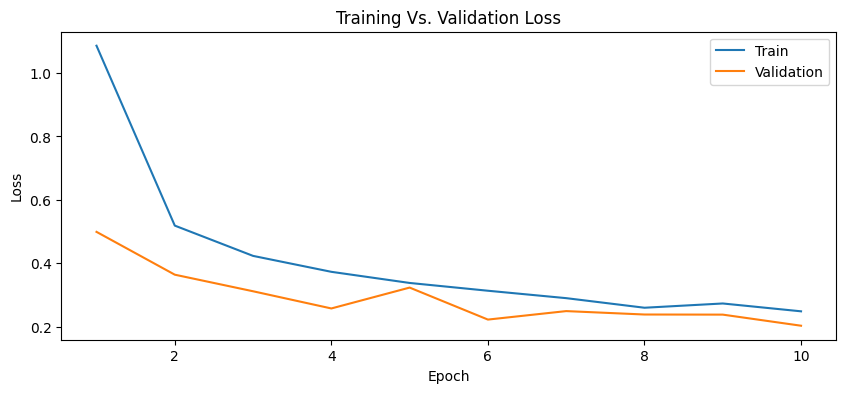

Final Training Loss: 0.2489, Accuracy: 0.9219
Final Validation Loss: 0.2035, Accuracy: 0.9333



TrainingResult(Training_accuracy=0.9218947368421053,
Training_loss=0.24888586778860344,
Validation_accuracy=0.9332817337461301,
Validation_loss=0.20348811628464206)

In [ ]:
resnet_model = Resnet50(num_classes, device).to(device)
alexnet_model = AlexNet(num_classes, device).to(device)
# vgg19_model = VGG19(num_classes, device).to(device)
googlenet_model = GoogLeNet(num_classes, device).to(device)

ensemble_model = EnsembleModel(resnet_model, alexnet_model, googlenet_model).to(device)

hyper_params_ensemble = dict(batch_size=32, learning_rate=0.001, num_epochs=10)
_, dataloaders_ensemble = get_data_loaders(**hyper_params_ensemble)
train_model(ensemble_model, dataloaders_ensemble, **hyper_params_ensemble)

During the application of transfer learning with the EnsembleModel model, we obtained a training accuracy of 92.19% and a validation accuracy of 93.33%.

The 'EnsembleModel_1' resembles the EnsembleModel, but with a change in the lineup of models. In this version, the models employed are ResNet, AlexNet, CNN (CropDisease), and GoogLeNet.

In [22]:
class EnsembleModel_1(nn.Module):
  def __init__(self, resnet, alexnet, cnn, googlenet):
    super(EnsembleModel_1, self).__init__()
    self.name = "Ensemble_1"
    self.resnet = resnet
    self.alexnet = alexnet
    self.cnn = cnn
    self.googlenet = googlenet

  def forward(self, x):
    # Resize input to match GoogLeNet's input size (299x299)
    x_googlenet = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

    # Forward pass for each model
    out_resnet = self.resnet(x)
    out_alexnet = self.alexnet(x)
    out_cnn = self.cnn(x)
    out_googlenet = self.googlenet(x_googlenet)

    # Combine predictions using majority voting
    ensemble_predictions = torch.mode(
          torch.stack([out_resnet, out_alexnet, out_cnn, out_googlenet], dim=1), dim=1
      ).values.squeeze()

    return ensemble_predictions

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `

----------
Epoch 1/10
---------- 

train loss: 1.1106, acc: 0.6954
val loss: 0.4743, acc: 0.8653
----------
Epoch 2/10
---------- 

train loss: 0.5454, acc: 0.8375
val loss: 0.4018, acc: 0.8683
----------
Epoch 3/10
---------- 

train loss: 0.4198, acc: 0.8721
val loss: 0.3381, acc: 0.9008
----------
Epoch 4/10
---------- 

train loss: 0.3632, acc: 0.8860
val loss: 0.3076, acc: 0.9082
----------
Epoch 5/10
---------- 

train loss: 0.3431, acc: 0.8914
val loss: 0.2596, acc: 0.9197
----------
Epoch 6/10
---------- 

train loss: 0.3215, acc: 0.9013
val loss: 0.2387, acc: 0.9234
----------
Epoch 7/10
---------- 

train loss: 0.3038, acc: 0.9059
val loss: 0.2451, acc: 0.9254
----------
Epoch 8/10
---------- 

train loss: 0.2806, acc: 0.9093
val loss: 0.2506, acc: 0.9245
----------
Epoch 9/10
---------- 

train loss: 0.2749, acc: 0.9118
val loss: 0.2183, acc: 0.9345
----------
Epoch 10/10
---------- 

train loss: 0.2624, acc: 0.9171
val loss: 0.2036, acc: 0.9339


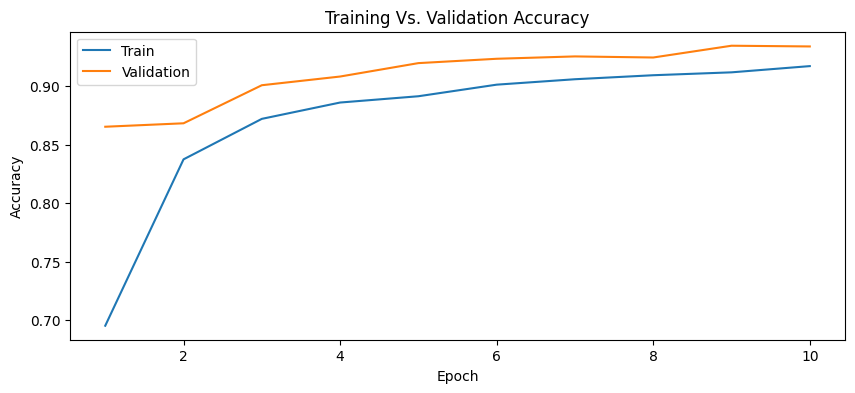

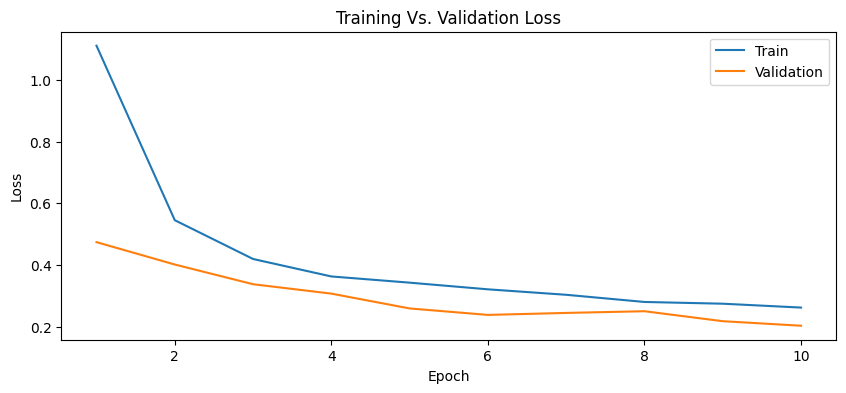

Final Training Loss: 0.2624, Accuracy: 0.9171
Final Validation Loss: 0.2036, Accuracy: 0.9339



TrainingResult(Training_accuracy=0.9171052631578948,
Training_loss=0.26241800026830875,
Validation_accuracy=0.9339009287925697,
Validation_loss=0.20363247025031422)

In [ ]:
resnet_model = Resnet50(num_classes, device).to(device)
alexnet_model = AlexNet(num_classes, device).to(device)
cnn_model = CropDisease().to(device)
googlenet_model = GoogLeNet(num_classes, device).to(device)

ensemble_model_1 = EnsembleModel_1(resnet_model, alexnet_model, cnn_model, googlenet_model).to(device)

hyper_params_ensemble = dict(batch_size=32, learning_rate=0.001, num_epochs=10)
_, dataloaders_ensemble = get_data_loaders(**hyper_params_ensemble)
train_model(ensemble_model_1, dataloaders_ensemble, **hyper_params_ensemble)

While employing transfer learning with the EnsembleModel_1 model, we achieved a training accuracy of 91.18% and a validation accuracy of 93.45%.







##**EVALUATION ON TEST DATA**

###Loading model parameters & finding test accuracy

Now after running all the models on the trained data, now we take the saved model data and we send the test data to find the accuracy of each model.

####CNN

In [13]:
# CNN
! gdown --id 1TE_iYoZSRQy20T7KHLNoPdFR2v4UgUMg             # Downloading "model_CropDisease_3_bs32_lr0.001_epoch15" file
cnn_test = CropDisease().to(device)
cnn_test.load_state_dict(torch.load('model_CropDisease_3_bs32_lr0.001_epoch15'))

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1TE_iYoZSRQy20T7KHLNoPdFR2v4UgUMg
To: /content/model_CropDisease_3_bs32_lr0.001_epoch15
100% 310M/310M [00:01<00:00, 241MB/s]


<All keys matched successfully>

In [ ]:
cnn_test_accuracy = get_accuracy(cnn_test, dataloader['test'])
cnn_test_accuracy

0.9029411764705882

####ResNet

In [25]:
# Resnet
! gdown --id 1T581AcYhCsiSaUzhstTJMrBkK6-hsPCP              # Downloading "model_Resnet50_bs32_lr0.001_epoch6" file
resnet_test = Resnet50(num_classes, device).to(device)
resnet_test.load_state_dict(torch.load('model_Resnet50_bs32_lr0.001_epoch6'))

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1T581AcYhCsiSaUzhstTJMrBkK6-hsPCP
To: /content/model_Resnet50_bs32_lr0.001_epoch6
100% 98.6M/98.6M [00:00<00:00, 129MB/s]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 59.5MB/s]


<All keys matched successfully>

In [ ]:
resnet_test_accuracy = get_accuracy(resnet_test, dataloader['test'])
resnet_test_accuracy

0.93343653250774

####AlexNet

In [26]:
# Alexnet
! gdown --id 1WYmRlj5G-E-7THSTDnZLAPYNxoXpxK-g              # Downloading "model_AlexNet_bs32_lr0.001_epoch9" file
alexnet_test = AlexNet(num_classes, device).to(device)
alexnet_test.load_state_dict(torch.load('model_AlexNet_bs32_lr0.001_epoch9'))

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1WYmRlj5G-E-7THSTDnZLAPYNxoXpxK-g
To: /content/model_AlexNet_bs32_lr0.001_epoch9
100% 178M/178M [00:02<00:00, 63.0MB/s]


Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 114MB/s]


<All keys matched successfully>

In [ ]:
alexnet_test_accuracy = get_accuracy(alexnet_test, dataloader['test'])
alexnet_test_accuracy

0.9212074303405573

####VGG19

In [27]:
# Vgg19
! gdown --id 1Q-gwvJZ8ymtSnydSS_ZdwSv-M8ZGiTlA              # Downloading "model_VGG19_bs32_lr0.001_epoch10" file
vgg19_test = VGG19(num_classes, device).to(device)
vgg19_test.load_state_dict(torch.load('model_VGG19_bs32_lr0.001_epoch10'))

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Q-gwvJZ8ymtSnydSS_ZdwSv-M8ZGiTlA
To: /content/model_VGG19_bs32_lr0.001_epoch10
100% 559M/559M [00:09<00:00, 60.5MB/s]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 89.4MB/s]


<All keys matched successfully>

In [ ]:
vgg19_test_accuracy = get_accuracy(vgg19_test, dataloader['test'])
vgg19_test_accuracy

0.8439628482972136

####GoogleNet

In [28]:
# Googlenet
! gdown --id 1PKZHWRfypz6z8VPFUay1U96JehR4SMrv              # Downloading "model_GoogLeNet_bs128_lr0.0015_epoch9" file
googlenet_test = GoogLeNet(num_classes, device).to(device)
googlenet_test.load_state_dict(torch.load('model_GoogLeNet_bs128_lr0.0015_epoch9'))

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1PKZHWRfypz6z8VPFUay1U96JehR4SMrv
To: /content/model_GoogLeNet_bs128_lr0.0015_epoch9
100% 22.7M/22.7M [00:00<00:00, 175MB/s]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 140MB/s]


<All keys matched successfully>

In [ ]:
googlenet_test_accuracy = get_accuracy(googlenet_test, dataloader['test'])
googlenet_test_accuracy

0.8803405572755418

####Hybrid Models

In [ ]:
# Hybrid
! gdown --id 1d3EHnV2WN7e5mKLSPq0Q99fN4_fJS1h3              # Downloading "model_Hybrid_bs32_lr0.001_epoch10" file
hybrid_test = Hybrid(resnet_test, alexnet_test, vgg19_test, googlenet_test).to(device)
hybrid_test.load_state_dict(torch.load('model_Hybrid_bs32_lr0.001_epoch10'))

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1d3EHnV2WN7e5mKLSPq0Q99fN4_fJS1h3
To: /content/model_Hybrid_bs32_lr0.001_epoch10
100% 858M/858M [00:10<00:00, 85.2MB/s]


<All keys matched successfully>

In [ ]:
hybrid_test_accuracy = get_accuracy(hybrid_test, dataloader['test'])
hybrid_test_accuracy

0.9317337461300309

In [ ]:
# Hybrid_1
! gdown --id 1K16AFWvqOjpTh-xaXTjMskEdLNAgVovV              # Downloading "model_Hybrid_1_bs32_lr0.001_epoch8" file
hybrid_1_test = Hybrid_1(resnet_test, alexnet_test, cnn_test, googlenet_test).to(device)
hybrid_1_test.load_state_dict(torch.load('model_Hybrid_1_bs32_lr0.001_epoch8'))

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1K16AFWvqOjpTh-xaXTjMskEdLNAgVovV
To: /content/model_Hybrid_1_bs32_lr0.001_epoch8
100% 609M/609M [00:06<00:00, 99.6MB/s]


<All keys matched successfully>

In [ ]:
hybrid_1_test_accuracy = get_accuracy(hybrid_1_test, dataloader['test'])
hybrid_1_test_accuracy

0.9321981424148607

####Ensemble Models

In [29]:
# Ensemble
! gdown --id 1O57a_M5lVNdrc6vo5AvC3n3om_I6MqxD              # Downloading "model_Ensemble_bs32_lr0.001_epoch10" file
ensemble_test = EnsembleModel(resnet_test, alexnet_test, googlenet_test).to(device)
ensemble_test.load_state_dict(torch.load('model_Ensemble_bs32_lr0.001_epoch10'))

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1O57a_M5lVNdrc6vo5AvC3n3om_I6MqxD
To: /content/model_Ensemble_bs32_lr0.001_epoch10
100% 299M/299M [00:01<00:00, 232MB/s]


<All keys matched successfully>

In [ ]:
ensemble_test_accuracy = get_accuracy(ensemble_test, dataloader['test'])
ensemble_test_accuracy

0.9385448916408669

In [ ]:
# Ensemble_1
! gdown --id 1qFg5MSDSd-uJuvbAD2OX2HhuSseO5qNS              # Downloading "model_Ensemble_1_bs32_lr0.001_epoch9" file
ensemble_1_test = EnsembleModel_1(resnet_test, alexnet_test, cnn_test, googlenet_test).to(device)
ensemble_1_test.load_state_dict(torch.load('model_Ensemble_1_bs32_lr0.001_epoch9'))

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qFg5MSDSd-uJuvbAD2OX2HhuSseO5qNS
To: /content/model_Ensemble_1_bs32_lr0.001_epoch9
100% 609M/609M [00:10<00:00, 58.2MB/s]


<All keys matched successfully>

In [ ]:
ensemble_1_test_accuracy = get_accuracy(ensemble_1_test, dataloader['test'])
ensemble_1_test_accuracy

0.9379256965944273

The best performing model was the 'EnsembleModel' with the test accuracy of 93.85%. Hence, this model is chosen for further analysis in making predictions on unseen images and videos.

##**RESULTS**

In [8]:
accuracy_data = {'Models': ['Train', 'Validation', 'Test'],
                 'CNN': ['96.18%', '92.06%', '90.29%'],
                 'ResNet50': ['92.32%', '93.16%', '93.34%'],
                 'AlexNet': ['86.97%', '92.23%', '92.12%'],
                 'VGG19': ['75.99', '83.48%', '84.40%'],
                 'GoogLeNet': ['92.44%', '93.42%', '88.03%'],
                 'Hybrid': ['93.55%', '93.17%', '93.17%'],
                 'Hybrid_1': ['92.65%', '93.45%', '93.22%'],
                 'Ensemble': ['92.19%', '93.33%', '93.85%'],
                 'Ensemble_1': ['91.18%', '93.45%', '93.79%'],}

# Creating the DataFrame
accuracy_df = pd.DataFrame(accuracy_data)
accuracy_df

Models     CNN ResNet50 AlexNet   VGG19 GoogLeNet  Hybrid Hybrid_1  \
0       Train  96.18%   92.32%  86.97%   75.99    92.44%  93.55%   92.65%   
1  Validation  92.06%   93.16%  92.23%  83.48%    93.42%  93.17%   93.45%   
2        Test  90.29%   93.34%  92.12%  84.40%    88.03%  93.17%   93.22%   

  Ensemble Ensemble_1  
0   92.19%     91.18%  
1   93.33%     93.45%  
2   93.85%     93.79%

#**UNSEEN DATA**

###Code for Images

In the below we are adding the word leaf to the class names to create a list of search terms to get images from bing.

In [14]:
class_names_with_leaf = [name + ' leaf' for name in class_names]
class_names_with_leaf = [name.replace(',', '') for name in class_names_with_leaf]

# Print the updated list
print(class_names_with_leaf)

['Apple___Apple_scab leaf', 'Apple___Black_rot leaf', 'Apple___Cedar_apple_rust leaf', 'Apple___healthy leaf', 'Blueberry___healthy leaf', 'Cherry_(including_sour)___Powdery_mildew leaf', 'Cherry_(including_sour)___healthy leaf', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot leaf', 'Corn_(maize)___Common_rust_ leaf', 'Corn_(maize)___Northern_Leaf_Blight leaf', 'Corn_(maize)___healthy leaf', 'Grape___Black_rot leaf', 'Grape___Esca_(Black_Measles) leaf', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot) leaf', 'Grape___healthy leaf', 'Orange___Haunglongbing_(Citrus_greening) leaf', 'Peach___Bacterial_spot leaf', 'Peach___healthy leaf', 'Pepper_bell___Bacterial_spot leaf', 'Pepper_bell___healthy leaf', 'Potato___Early_blight leaf', 'Potato___Late_blight leaf', 'Potato___healthy leaf', 'Raspberry___healthy leaf', 'Soybean___healthy leaf', 'Squash___Powdery_mildew leaf', 'Strawberry___Leaf_scorch leaf', 'Strawberry___healthy leaf', 'Tomato___Bacterial_spot leaf', 'Tomato___Early_blight leaf

In [23]:
!pip install bing-image-downloader

In [62]:
#Predict
class_names= data['train'].classes

In [63]:
model_directory = '/content/model_Ensemble_bs32_lr0.001_test'


# Create the directory if it doesn't exist
os.makedirs(model_directory, exist_ok=True)

# Save the model's state dictionary
model_path = os.path.join(model_directory, 'model.pth')
torch.save(ensemble_test.state_dict(), model_path)

In [ ]:
ensemble_test = EnsembleModel(resnet_test, alexnet_test, googlenet_test).to(device)

# Load the trained weights
model_path = '/content/model_Ensemble_bs32_lr0.001_test/model.pth'
ensemble_test.load_state_dict(torch.load(model_path, map_location=device))
ensemble_test.eval()

In [ ]:
# Downloading unseen images from Bing downloader
from bing_image_downloader import downloader
for query_string in class_names_with_leaf:
  downloader.download(query_string, limit=10,  output_dir='unseen_sample', adult_filter_off=True, force_replace=False, timeout=60, verbose=True)

In [34]:
# Converting the unseen images to zip file
import shutil

folder_path = '/content/unseen_sample'
zip_file_name = 'Unseen_Sample_web_extract'
shutil.make_archive(zip_file_name, 'zip', folder_path)
print(f'The folder "{folder_path}" has been successfully zipped to "{zip_file_name}".')

The folder "/content/unseen_sample" has been successfully zipped to "Unseen_Sample_web_extract".


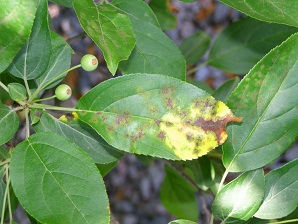

Do you want to keep this image? (y/n): 
y
Selected Image: Image_2.jpg
Subfolder Name: Apple___Apple_scab leaf


In [136]:
#Choose a random image from the unseen dataset and check whether the image is the correct image.
import random
from IPython.display import Image, display

# Extracting the downloaded 'Unseen_Sample_web_extract' as 'unseen_sample'
with zipfile.ZipFile('Unseen_Sample_web_extract.zip', 'r') as zip_ref:
  zip_ref.extractall('unseen_sample')

# Specify the parent directory containing subfolders with images
parent_directory = '/content/unseen_sample'

# Get a list of subfolders
subfolders = [f.path for f in os.scandir(parent_directory) if f.is_dir()]
i=1

# Loop until a suitable image is found
while True:
    # Randomly choose a subfolder
    selected_subfolder = random.choice(subfolders)

    # List all files in the selected subfolder
    all_files = os.listdir(selected_subfolder)

    # Randomly choose an image from the subfolder
    selected_image = random.choice(all_files)

    # Display the image for manual inspection
    image_path = os.path.join(selected_subfolder, selected_image)
    display(Image(filename=image_path))

    # Ask the user to input whether to keep the image
    print("Do you want to keep this image? (y/n): ")
    user_input = input()

    # If the user chooses to keep the image, break the loop
    if user_input.lower() == 'y':
        break

# Save the subfolder name into a variable
subfolder_name = os.path.basename(selected_subfolder)

# Now you can use the selected image and the subfolder name for further use
print(f"Selected Image: {selected_image}")
print(f"Subfolder Name: {subfolder_name}")


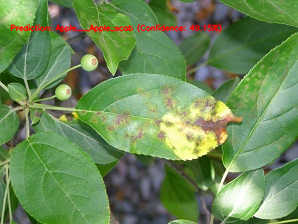

Actual Class: Apple___Apple_scab leaf


In [138]:
import cv2
from google.colab.patches import cv2_imshow

# Function to perform object detection on frame using your PyTorch model

def detect_crop_disease(frame, classes):

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Preprocess the frame
    input_tensor = transform(frame).unsqueeze(0).to(device)

    # Perform inference using the Ensemble model
    with torch.no_grad():
        outputs = ensemble_test(input_tensor)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
        confidence_percentage = confidence[predicted.item()].item()

    predicted_class = classes[predicted.item()]

    # Display the prediction and confidence score on the frame
    cv2.putText(frame, f'Prediction: {predicted_class} (Confidence: {confidence_percentage:.2f}%)',
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0, 0, 255), 1, cv2.LINE_AA)

    return frame

image = cv2.imread(image_path)
output_frame = detect_crop_disease(image, class_names)
cv2_imshow(output_frame)
print(f"Actual Class: {subfolder_name}")

The actual image class is 'Apple___Apple_scab leaf', and the model predicted it correctly as 'Apple___Apple_scab' with a confidence of 49.15%. This low confidence percentage is attributed to the presence of many leaves in the background.

## **Code for Video**

The below code takes the uploaded video and split it into each frame image. Then the frame image is uploaded to our ensemble model and the model predicts what crop and its diease is present in the frame. Then the frames are stitch back together and saved in the Google Colab directory.

In [68]:
pip install opencv-python

In [69]:
class_names= data['train'].classes

In [143]:
# Unseen video 1

import cv2
from google.colab.patches import cv2_imshow

# Function to perform object detection on frame using your PyTorch model

def detect_crop_disease_video(frame, classes):

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Preprocess the frame
    input_tensor = transform(frame).unsqueeze(0).to(device)

    # Perform inference using the GoogLeNet model
    with torch.no_grad():
        outputs = ensemble_test(input_tensor)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
        confidence_percentage = confidence[predicted.item()].item()

    predicted_class = classes[predicted.item()]

    # Display the prediction and confidence score on the frame
    cv2.putText(frame, f'Prediction: {predicted_class} (Confidence: {confidence_percentage:.2f}%)',
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0, 0, 255), 1, cv2.LINE_AA)

    return frame

# Open a video capture
video_path = '/content/UnseenVideo_1.mp4'
output_video_path = '/content/output_video_1.mp4'
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create a VideoWriter object to write the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'XVID' is a common codec, adjust as needed
out = cv2.VideoWriter(output_video_path, fourcc, fps, (640, 480))


frame_skip = 1
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % frame_skip == 0:
        resized_frame = cv2.resize(frame, (640, 480))
        # Perform object detection and display the resized frame
        output_frame = detect_crop_disease_video(resized_frame, class_names)
        #cv2_imshow(output_frame)
        #processed_frame = cv2.cvtColor(output_frame, cv2.COLOR_BGR2GRAY)# Replace with your processing logic
        out.write(output_frame)

    else:
        # Write the original frame to the output video
        frame = cv2.resize(frame, (640, 480))
        out.write(frame)


    frame_count += 1
# Release video capture and close windows
cap.release()
out.release()
cv2.destroyAllWindows()

print("Video predeiction completed.")

Video predeiction completed.


In [144]:
# Unseen video 2
# Open a video capture
video_path = '/content/UnseenVideo_2.mp4'
output_video_path = '/content/output_video_2.mp4'
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create a VideoWriter object to write the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'XVID' is a common codec, adjust as needed
out = cv2.VideoWriter(output_video_path, fourcc, fps, (640, 480))


frame_skip = 1
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % frame_skip == 0:
        resized_frame = cv2.resize(frame, (640, 480))
        # Perform object detection and display the resized frame
        output_frame = detect_crop_disease_video(resized_frame, class_names)
        #cv2_imshow(output_frame)
        #processed_frame = cv2.cvtColor(output_frame, cv2.COLOR_BGR2GRAY)# Replace with your processing logic
        out.write(output_frame)

    else:
        # Write the original frame to the output video
        frame = cv2.resize(frame, (640, 480))
        out.write(frame)


    frame_count += 1
# Release video capture and close windows
cap.release()
out.release()
cv2.destroyAllWindows()

print("Video predeiction completed.")

Video predeiction completed.


# **Summary**

For this project, we have gathered a substantial amount of data. However, due to technical constraints and time limitations, we have chosen to use only a portion of the dataset for this report. The complete dataset, totaling 3GB, requires considerable time for both uploading and processing. As a result, we have focused our analysis specifically on a subset of the data pertaining to apple crops.<br>

Link to dataset: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset/data

Our project aimed to detect diseases in crops by analyzing their leaves. To begin with, we identified and collected data on 38 different types of crop diseases from Kaggle platform. The first step involved preparing the data, which included cleaning, organizing, resizing and data loading process of the images for analysis.<br>

To create an effective model, we designed our own CNN (Convolutional Neural Network) architecture with 4 convolution layers, 4 pooling and 3 fully connected layers. We checked the model's performance to ensure it was working correctly, using sanity checking on a small dataset to see if the model overfits. Following this, we fine-tuned the model by adjusting various hyper-parameters to enhance its validation accuracy. The following hyper-parameters were tuned: Kernel Size, Learning Rate, Batch size and number of epochs.<br>

We then incorporated the use of pre-existing models such as ResNet50, AlexNet, GoogLeNet, and VGG19, training these models on our dataset. Additionally, we experimented with hybrid models, combining these pre-trained models to leverage their individual strengths. The outputs from each model were merged and passed through a linear layer to predict diseases for the hybrid models.<br>

One of our approaches involved an ensemble model where multiple pre-trained models were combined, and predictions were based on the majority vote among these models. The ensemble model performed the best based on our evaluations. <br>

To further validate our model's effectiveness, we collected new, unseen data by scraping images using a Bing downloader. Using the best-performing model, we made predictions on these new images. Additionally, we tested our model's capability on unseen videos. The videos were collected from YouTube. We made predictions on the video by extracting frames using OpenCV, predicting diseases for each frame, and reconstructing the video with disease predictions overlaid. <br>

The final outcome was a video that showcased the predictions made by our model for the unseen videos. This video exhibited the potential application of our model in real-time scenarios, demonstrating how it could accurately detect crop diseases in both images and videos while at the same time showcased where our model lacks wherein when distractions are present in the background, the model was not able to perform effectively. Furthermore, other deep learning techniques like segmentation can be incorporated to focus on the primary things that help in determining the crop disease.<br>

In conclusion, our project focused on developing and refining a robust model for crop disease detection, utilizing various techniques and models to achieve accurate predictions on both images and video data.

# **DISCUSSION AND INSIGHTS GAINED**

i. We learnt how to leverage the power of pre-trained models and thereby incorporating transfer learning to enhance the overall performance of the model.

ii. Identified future opportunities, such as exploring other deep learning techniques like image segmentation, which can be utilized to enhance the model.

iii. Recognized the significance of quantitative metrics like sanity checks.

iv. We learned how to handle large data by uploading the dataset to the google drive and copying the file id and making use of it to upload it to colab.

v. Handling model data: Saving the model checkpoints periodically is essential to avoid restarting the training process from scratch each time. This is crucial because deep learning models are time-consuming and can pose memory issues.  

vi. Our dataset consists of images whose primary focus were leaves only which can be improved by adding its seed bearing structure as well.

vii. Segmentation can be performed to choose only the parts of main focus, for us being the leaves.


# **References**

i. https://www.nature.com/articles/s41598-023-34549-2#Sec2

ii. https://link.springer.com/article/10.1007/s11263-015-0816-y#Sec8

iii. https://ieeexplore.ieee.org/abstract/document/8697390?casa_token=i_XixiTyHxsAAAAA:Tew6iGq0J-STKr60GWWV0wLYt0qstxWGXbAOlI9iXgjQDpBpY9C7ZI3FU-mwAPhvMQWZWc0_

iv. https://www.frontiersin.org/articles/10.3389/fpls.2016.01419/full
<br>
<br>

Video data links

i. https://www.youtube.com/watch?v=bpuQPf5U64I&ab_channel=GaryPilarchik%28TheRustedGarden%29

ii. https://www.youtube.com/watch?v=6fWovA5_JYc&ab_channel=BayerCropScienceUS

iii. https://www.youtube.com/watch?v=agIwEBm7Zao&ab_channel=OklahomaGardening

iv. https://www.youtube.com/watch?v=RSEnWRRKdVk&ab_channel=backyardfarmer

v. https://www.youtube.com/watch?v=kX6TZ16hM8w&ab_channel=Thida%27sGarden